# Multiple trials

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%aimport simulation
%aimport mathf
%aimport util
%aimport graph
%aimport hyper

In [2]:
import os.path
from datetime import datetime
import numpy as np
from scipy import stats
from scipy import linalg
from sklearn.decomposition.factor_analysis import FactorAnalysis
from scipy.io import loadmat, savemat
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.tsa.tsatools import lagmat, lagmat2ds
import pandas as pd
from scipy.linalg import orth
from numpy.linalg import norm
from numpy import dstack, rollaxis

import simulation, util, graph, hyper, vlgp
from mathf import ichol_gauss, subspace
from util import rad2deg, rotate, add_constant

In [3]:
# plot setting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
from matplotlib import colors
from matplotlib import gridspec
from matplotlib import cm
from matplotlib.patches import FancyBboxPatch
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import set_matplotlib_formats
import seaborn as sns

/Users/yuan/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
sns.set_style("white")
PLDScolor = sns.xkcd_rgb["pale red"]
GPFAcolor =  sns.xkcd_rgb["medium green"]
vLGPcolor = sns.xkcd_rgb["denim blue"]

In [5]:
samplepath = os.path.expanduser("~/data/sample")
outputpath = os.path.expanduser("~/data/output")
figurepath = os.path.expanduser("~/variational-doc/figure")

## Lorenz latent

In [6]:
# dimensions
nsample = 5
ntrial = 10
ntime = 1000
nspike = 50
nlatent = 3

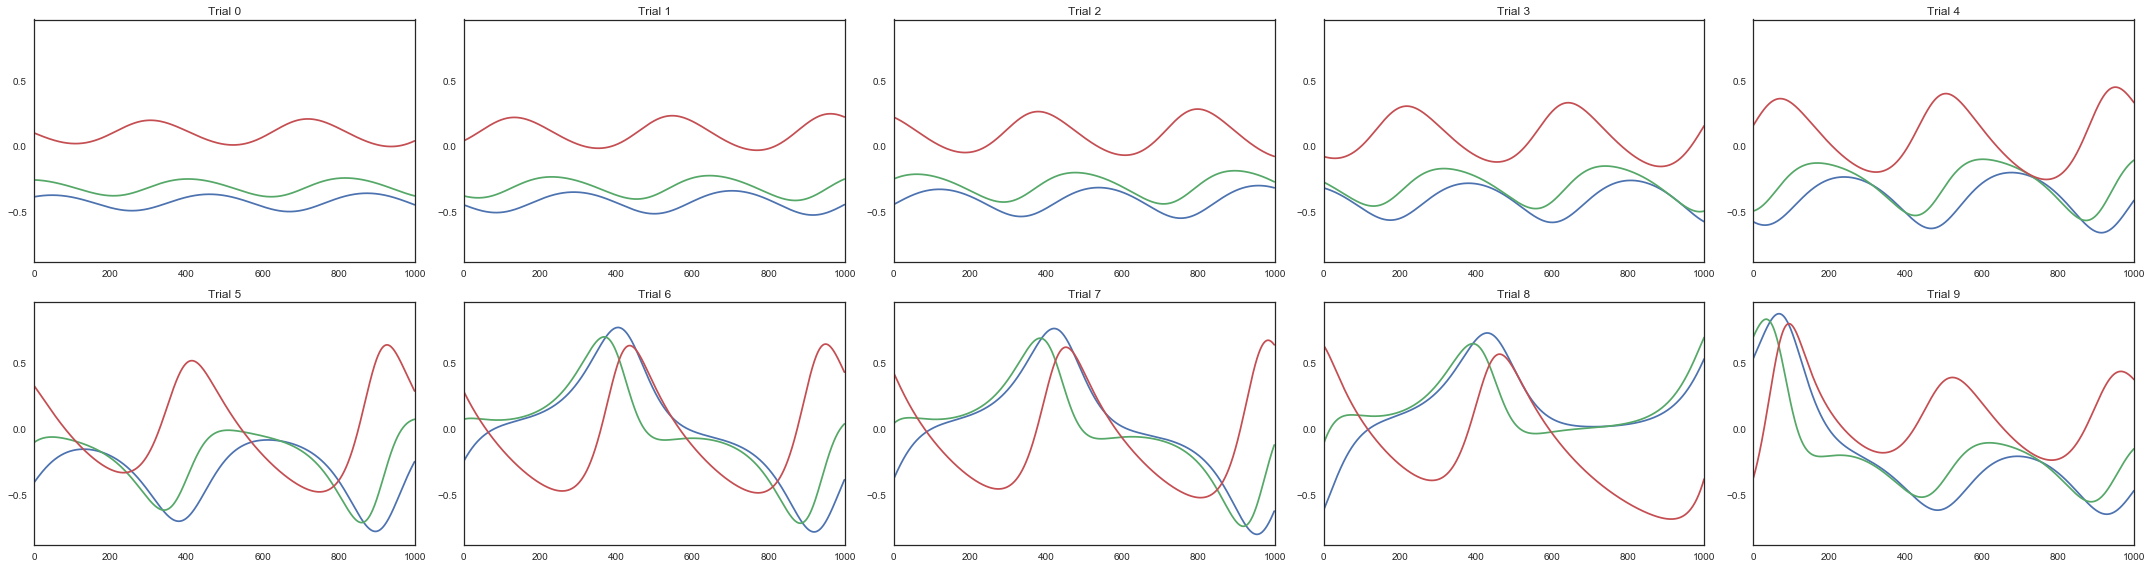

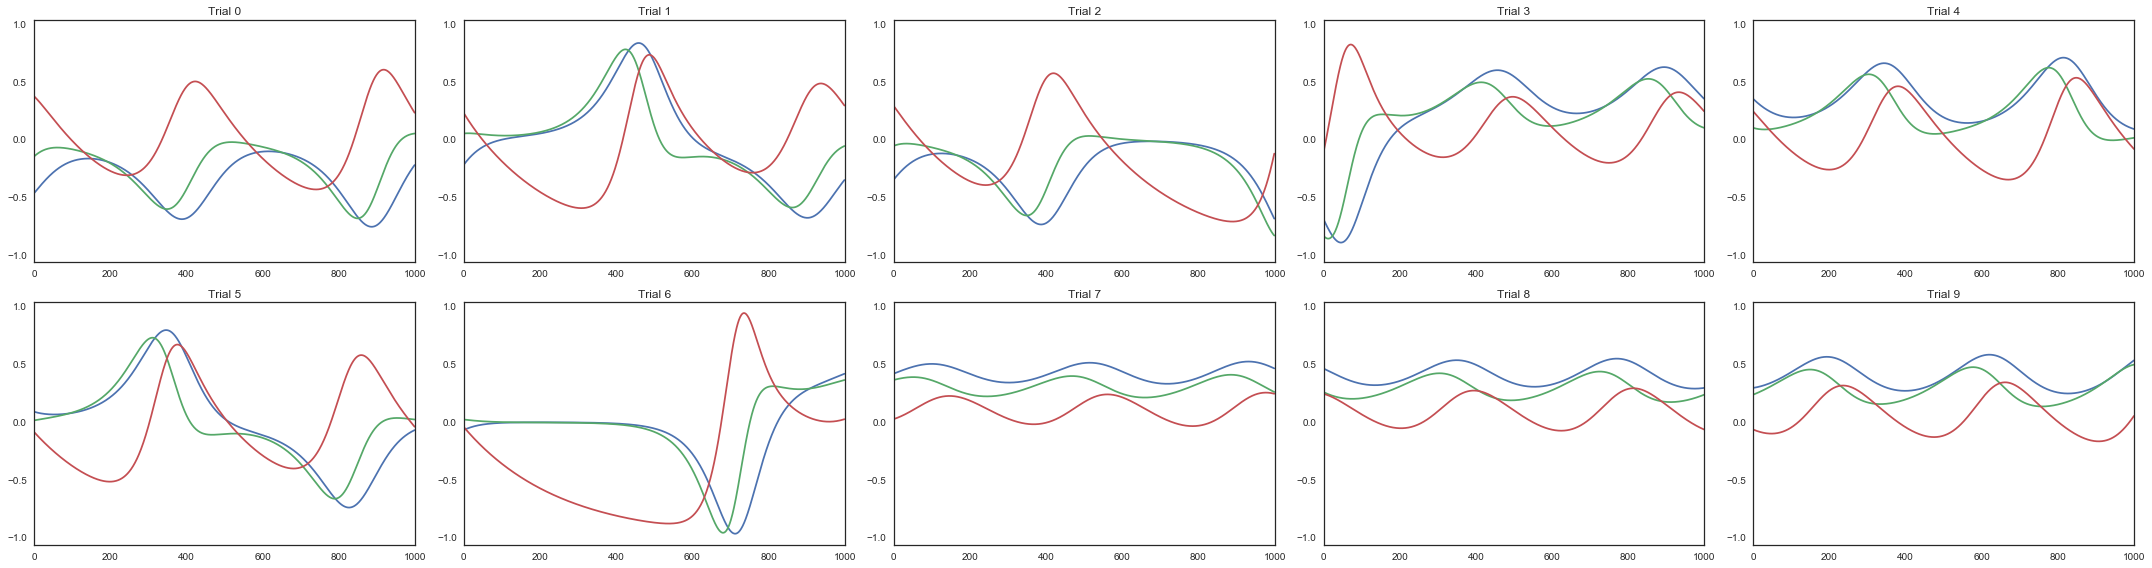

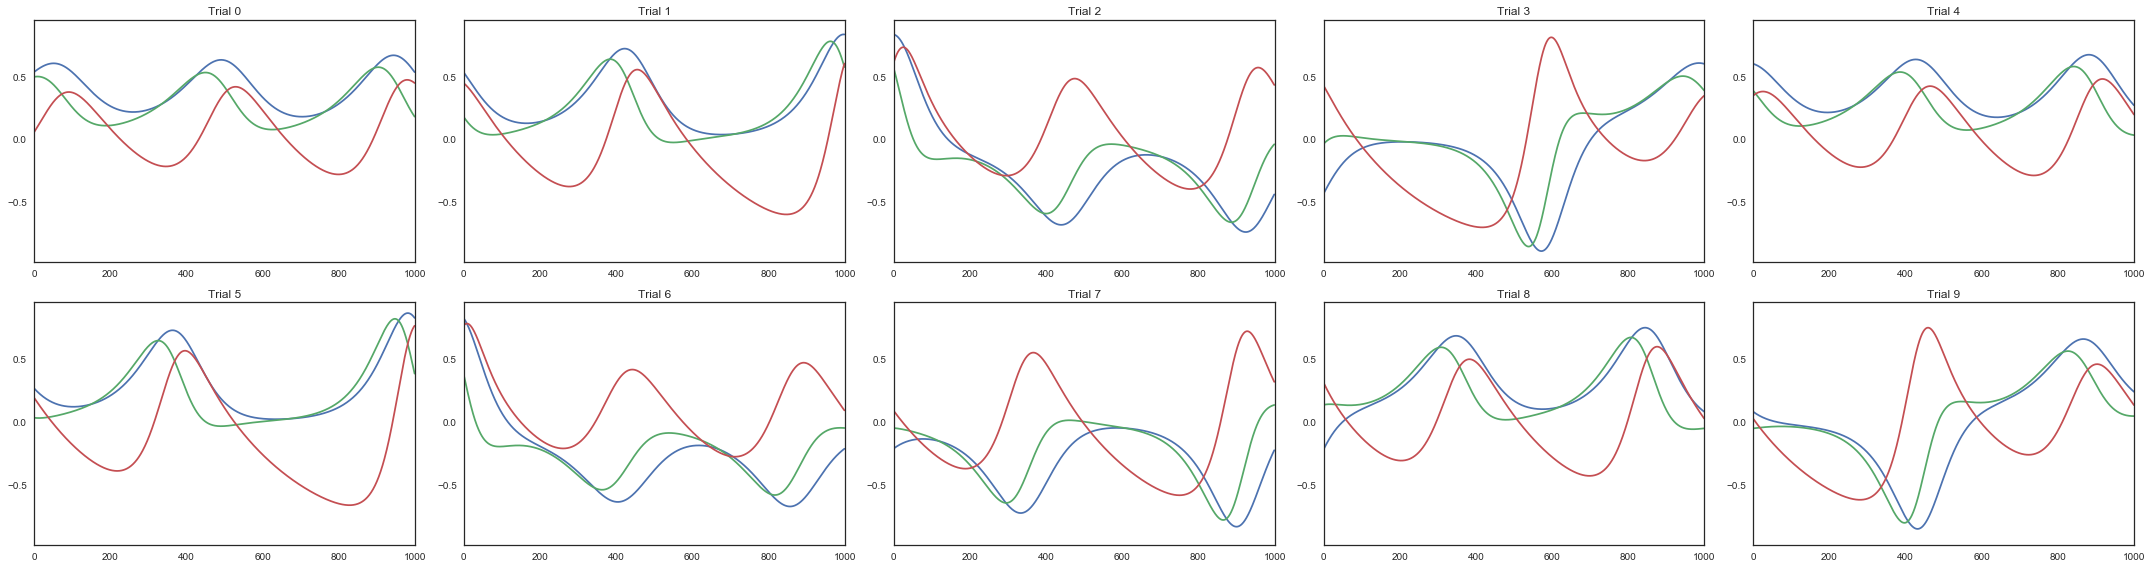

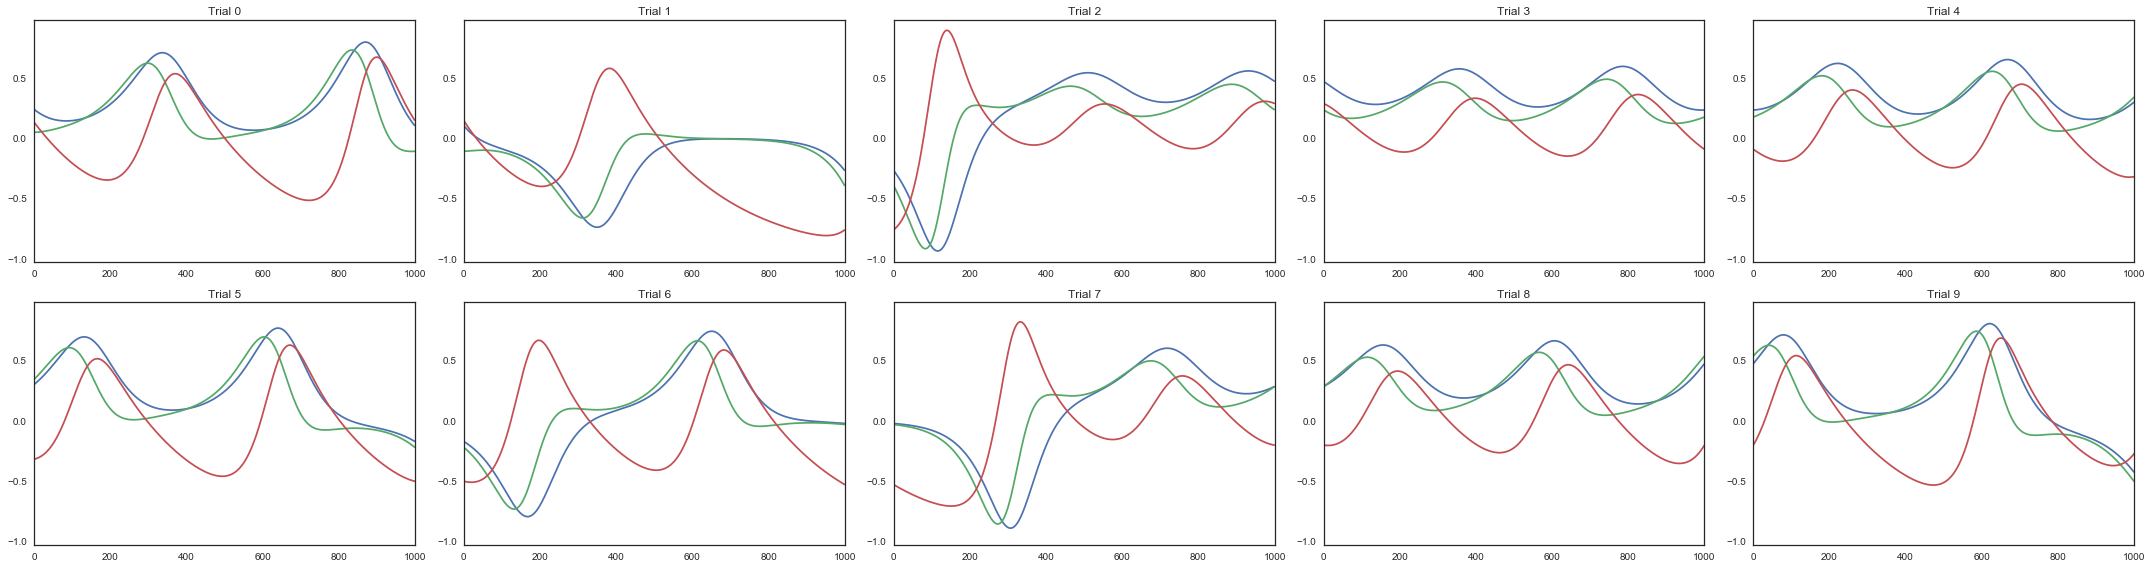

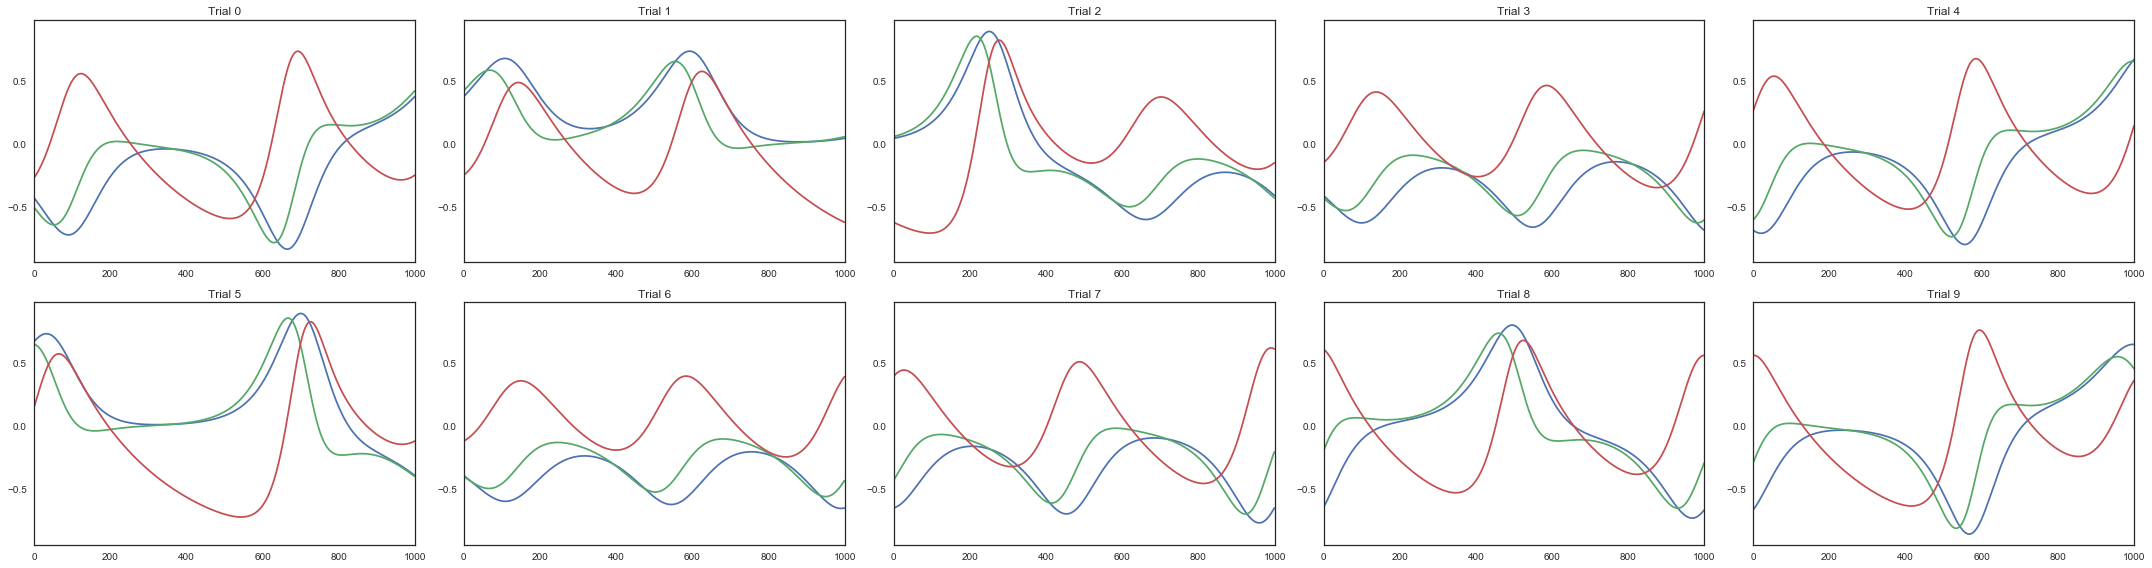

In [707]:
np.random.seed(0)
skip = 2000
lorenz = simulation.lorenz(skip + nsample * ntrial * ntime, dt=1.5e-3, x0=np.random.random(3) * 2)
lorenz = (lorenz - lorenz.mean(axis=0)) / norm(lorenz, axis=0, ord=np.inf)
x = lorenz[skip:, :].reshape((nsample, ntrial, ntime, -1))
for i in range(5):
    graph.dynplot(x[i, :], ncol=5)

# Simulate spike trains

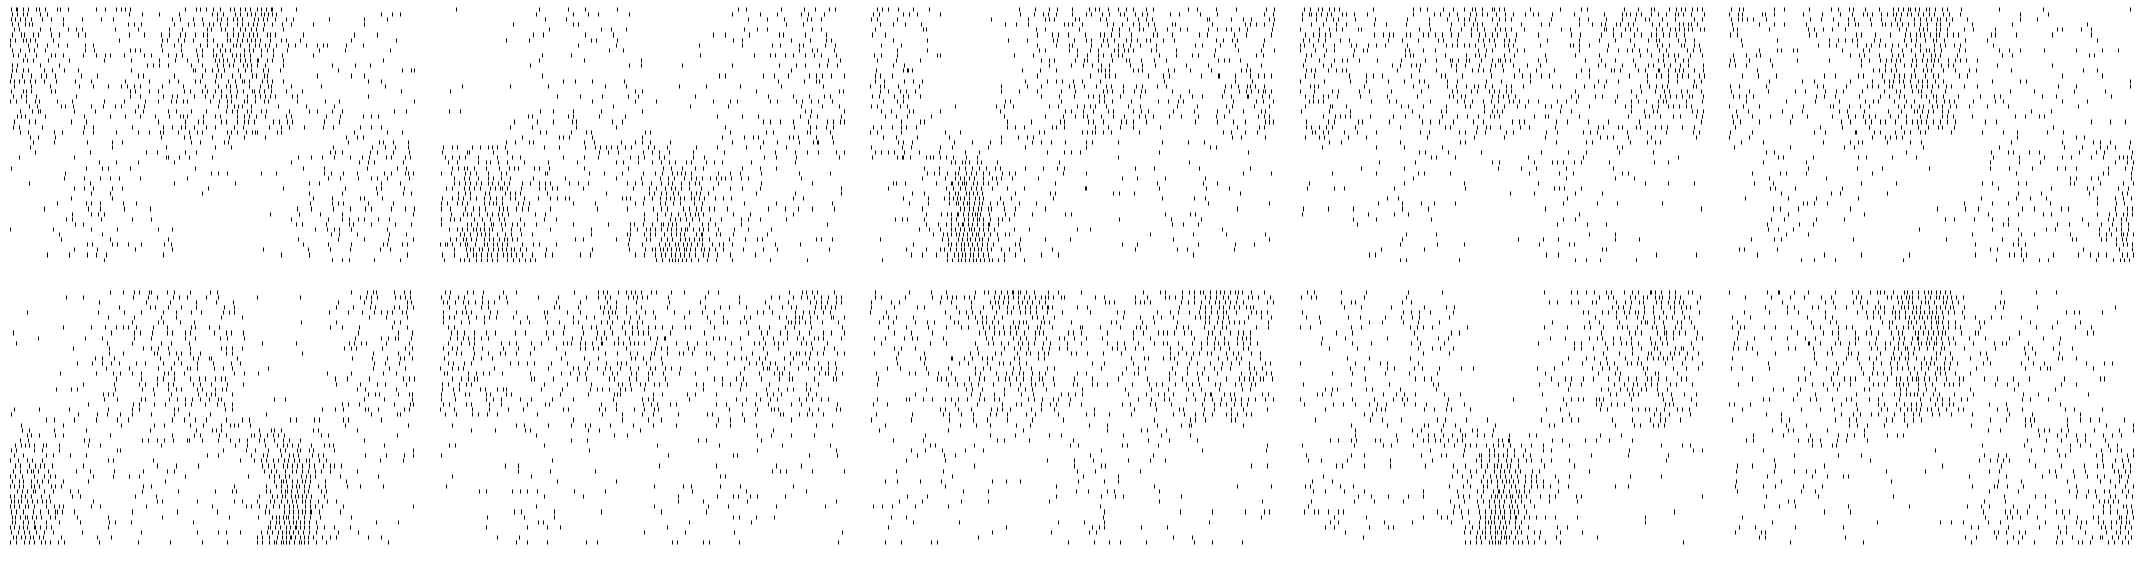

In [761]:
np.random.seed(0)
low = np.log(15 / ntime)
aspk = np.sort((np.random.rand(nlatent, nspike) + 1) * np.sign(np.random.randn(nlatent, nspike)), axis=1)
bspk = np.vstack((low * np.ones(nspike), -10 * np.ones(nspike), -10 * np.ones(nspike), -3 * np.ones(nspike), 
                  -3 * np.ones(nspike), -3 * np.ones(nspike), -3 * np.ones(nspike), -2 * np.ones(nspike),
                  -2 * np.ones(nspike), -1 * np.ones(nspike), -1 * np.ones(nspike)))

y = np.empty((nsample, ntrial, ntime, nspike))  # spike trains
rate = np.empty_like(y)  # firing rates
LorenzSample = []
fsample = []

for i in range(nsample):
    y[i, :], _, rate[i, :] = simulation.spike(x[i, :], aspk, bspk)
#     print('mean firing rate per neuron', y.mean(axis=(0, 1)) * 1000)
    LorenzSample.append({'y': y[i, :], 'rate': rate[i, :], 'x': x[i, :], 'alpha': aspk, 'beta':bspk})
    fname = '{}/lorenz_{}'.format(samplepath, i + 1)
    fsample.append(fname)
    savemat(fname, LorenzSample[i])
graph.rasterplot(y[nsample - 1, :], ncol=5);

In [1284]:
for i in range(nsample):
    print('Sample {}'.format(i + 1))
    print('\t Mean spike per neuron\n\t', LorenzSample[i]['y'].mean(axis=(0, 1)) * ntime)
    print('\t Mean spike\n\t', LorenzSample[i]['y'].mean() * ntime)

Sample 1
	 Mean spike per neuron
	 [ 29.2  30.5  27.9  26.9  27.   28.1  27.7  26.3  26.4  25.9  25.3  26.7
  25.4  23.7  23.6  22.8  22.9  23.6  22.   22.5  22.5  19.1  20.3  19.4
  21.2  12.3  12.    9.6  11.3   9.8  10.3  11.2  11.6  10.6  10.3  12.
  10.5  10.1  10.8  11.1  11.5  10.9  10.7  12.4  11.   10.6  11.3  11.1
  11.    9.7]
	 Mean spike
	 17.812
Sample 2
	 Mean spike per neuron
	 [ 16.5  17.6  18.   15.4  17.1  15.9  17.9  15.3  16.2  15.8  16.9  14.8
  16.4  15.8  15.4  15.8  13.9  16.2  15.6  16.9  15.   13.2  15.3  14.7
  13.1  13.8  12.9  20.3  19.2  21.2  19.   19.3  20.4  18.4  22.3  23.1
  21.7  23.7  22.2  23.4  24.2  24.1  24.6  25.1  25.1  25.4  26.8  27.2
  28.2  27. ]
	 Mean spike
	 19.066
Sample 3
	 Mean spike per neuron
	 [ 18.5  19.3  18.8  17.7  16.9  16.2  18.3  16.5  15.5  17.8  18.1  14.8
  15.8  16.7  14.3  16.3  16.5  15.4  15.4  16.   15.6  16.8  14.6  14.7
  15.7  13.8  14.7  17.5  20.5  20.   18.1  18.3  17.5  21.3  20.7  21.9
  22.7  21.1  22.4  2

In [1006]:
fLorenzSample = ['{}/lorenz_{}'.format(samplepath, i + 1) for i in range(nsample)]

for i, fname in enumerate(fLorenzSample):
    print('Sample {}'.format(i + 1))
    sigma = np.full(nlatent, fill_value=1.0)
    omega = np.full(nlatent, fill_value=1e-5)
    sample = loadmat(fname, squeeze_me=True)
    result = vlgp.fit(sample['y'], ['spike'] * sample['y'].shape[-1], sigma, omega, x=sample['x'], 
                                   alpha=sample['alpha'], beta=sample['beta'], lag=10, rank=100, 
                                   niter=100, tol=1e-5, verbose=False, learn_omega=True)
    savemat('{}/lorenz_{}_vLGP'.format(outputpath, i + 1), result)
print('Done.')

# Collect results
Lorenz_vLGP = []
for i, fname in enumerate(fLorenzSample):
    Lorenz_vLGP.append(loadmat('{}/lorenz_{}_vLGP'.format(outputpath, i + 1), squeeze_me=True))

Sample 1
Sample 2
Sample 3
Sample 4
Sample 5
Done.


In [1009]:
# cv
fLorenzSample = ['{}/lorenz_{}'.format(samplepath, i + 1) for i in range(nsample)]
LorenzCV_vLGP = []

for i, fname in enumerate(fLorenzSample):
    print('Sample {}'.format(i + 1))
    sigma = np.full(nlatent, fill_value=1.0)
    omega = Lorenz_vLGP[i]['omega']
    sample = loadmat(fname, squeeze_me=True)
    result = vlgp.cv(sample['y'], ['spike'] * sample['y'].shape[-1], sigma, omega, lag=10, rank=100, 
                                   niter=100, tol=1e-5, learn_omega=True)
    savemat('{}/lorenz_{}_vLGP_pred'.format(outputpath, i + 1), result)
    LorenzCV_vLGP.append(result)
print('Done.')

Sample 1
Sample 2
Sample 3
Sample 4
Sample 5
Done.


Sample 3
Latent subspace angle: 40.02 deg
Loading subspace angle: 84.24 deg


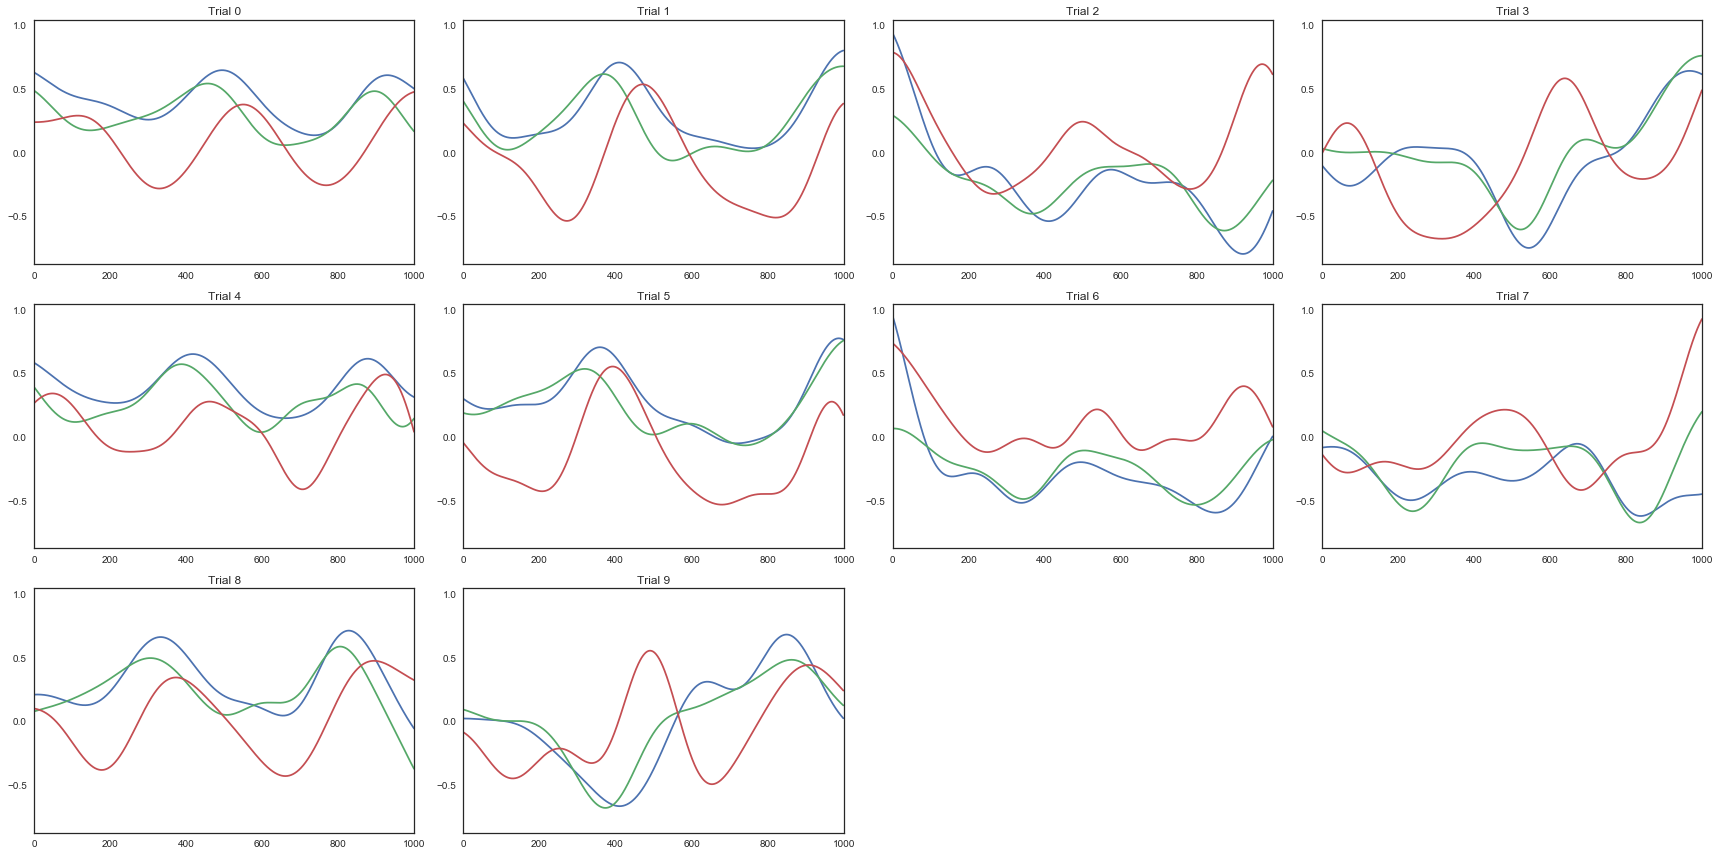

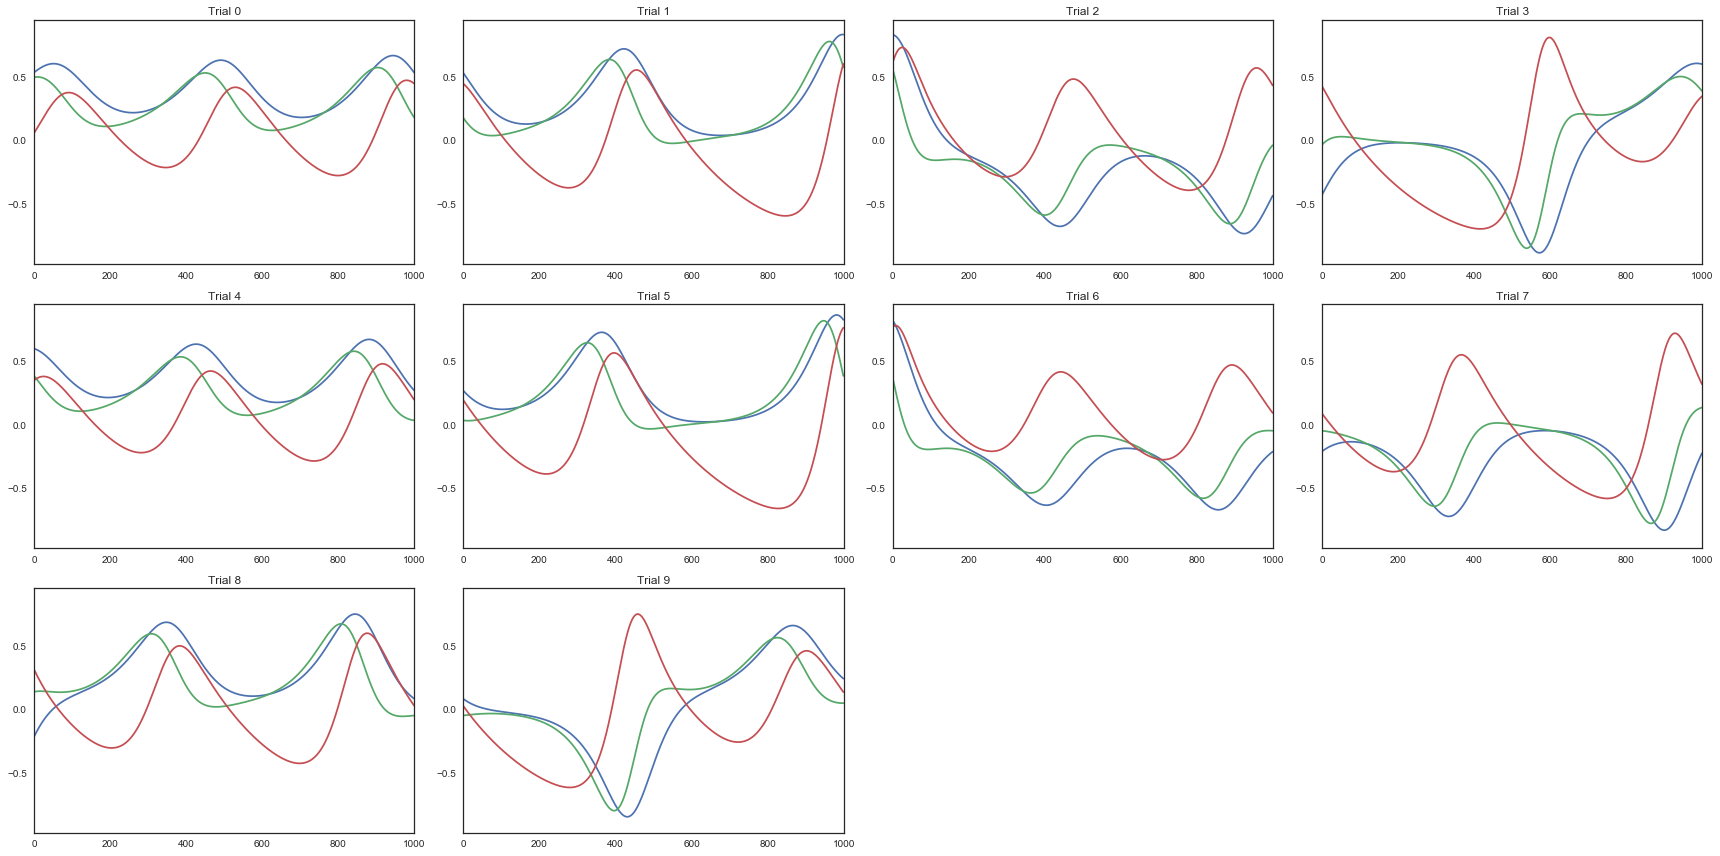

In [1287]:
idx = np.array([r['LatentAngle'][-1] for r in Lorenz_vLGP]).argmin()
# idx = 2
print('Sample {}'.format(idx + 1))
bestvLGP = Lorenz_vLGP[idx]
print('Latent subspace angle: {:.2f} deg'.format(rad2deg(bestvLGP['LatentAngle'][-1])))
print('Loading subspace angle: {:.2f} deg'.format(rad2deg(bestvLGP['LoadingAngle'][-1])))
# bestvLGPx = util.align(bestvLGP['mu'])
bestvLGPx = bestvLGP['mu']
rotated = np.empty_like(bestvLGPx)
for i in range(ntrial):
    rotated[i, :] = util.rotate(util.add_constant(bestvLGPx[i, :]), bestvLGP['x'][i, :])

# rotated = util.align(rotated)
graph.dynplot(rotated.reshape((ntrial, -1, nlatent)))
graph.dynplot(bestvLGP['x'])
# plt.savefig(os.path.join(outputpath, 'best_proposed_rotation_lorenz_sample.pdf'))


# fig, ax = plt.subplots(1, 2, figsize=(16, 6), subplot_kw=dict(projection='3d'))
# # recon = rotated.reshape((-1, nlatent))
# for m in range(ntrial):
#     ax[0].plot(rotated[m, :, 0], rotated[m, :, 1], rotated[m, :, 2], lw=1, color=vLGPcolor);
# # ax[0].plot(recon[:, 0], recon[:, 1], recon[:, 2], lw=1);
# ax[0].set_xlim3d(-1, 1);
# ax[0].set_ylim3d(-1, 1);
# ax[0].set_zlim3d(-1, 1);
# ax[0].set_title('Proposed reconstruction of Sample {}'.format(idx + 1));
# ax[1].plot(bestvLGP['x'].reshape((-1, nlatent))[:, 0], bestvLGP['x'].reshape((-1, nlatent))[:, 1], bestvLGP['x'].reshape((-1, nlatent))[:, 2], lw=1);
# ax[1].set_xlim3d(-1, 1);
# ax[1].set_ylim3d(-1, 1);
# ax[1].set_zlim3d(-1, 1);
# ax[1].set_title('True latent of Sample {}'.format(idx + 1));

In [534]:
# Run GPFA before loading GPFA results
Lorenz_GPFA = []
for i, fname in enumerate(fLorenzSample):
    Lorenz_GPFA.append(loadmat('{}/lorenz_{}_GPFA'.format(outputpath, i + 1), squeeze_me=True))

Sample 1
Latent subspace angle: 60.03 deg
Loading subspace angle: 80.50 deg
50.3027709059


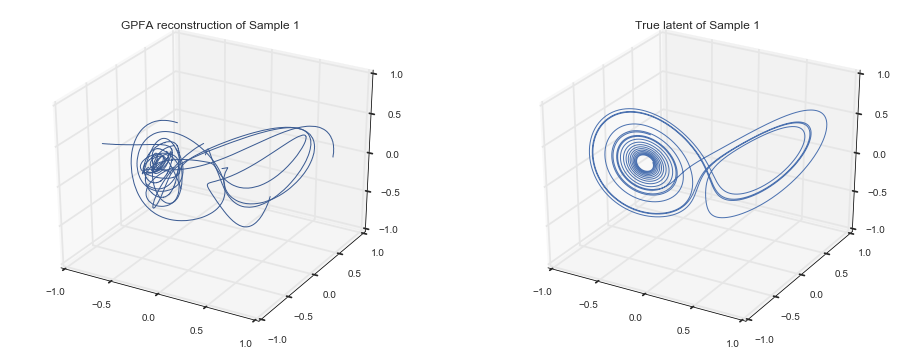

In [596]:
idx = np.array([r['latentAngle'][-1] for r in Lorenz_GPFA]).argmin()
print('Sample {}'.format(idx + 1))
bestGPFA = Lorenz_GPFA[idx]
print('Latent subspace angle: {:.2f} deg'.format(rad2deg(bestGPFA['latentAngle'][-1])))
print('Loading subspace angle: {:.2f} deg'.format(rad2deg(bestGPFA['loadingAngle'][-1])))
bestmu = np.rollaxis(np.dstack(bestGPFA['seqTrain']['xsm']), axis=-1).transpose((0, 2, 1))
bestx = np.rollaxis(np.dstack(bestGPFA['seqTrain']['x']), axis=-1).transpose((0, 2, 1))
rotated = np.empty_like(bestmu)

for i in range(ntrial):
    rotated[i, :] = util.rotate(util.add_constant(bestmu[i, :]), bestx[i, :])

# rotated = util.align(rotated)
print(rad2deg(subspace(rotated.reshape((-1, nlatent)), bestx.reshape((-1, nlatent)))))
# graph.dynplot(rotated.reshape((ntrial, -1, nlatent)))
# graph.dynplot(bestx)

fig, ax = plt.subplots(1, 2, figsize=(16, 6), subplot_kw=dict(projection='3d'))
# recon = rotated.reshape((-1, nlatent))
for m in range(ntrial):
    ax[0].plot(rotated[m, :, 0], rotated[m, :, 1], rotated[m, :, 2], lw=1, color=vLGPcolor);
ax[0].set_xlim3d(-1, 1);
ax[0].set_ylim3d(-1, 1);
ax[0].set_zlim3d(-1, 1);
ax[0].set_title('GPFA reconstruction of Sample {}'.format(idx + 1));
ax[1].plot(bestx.reshape((-1, nlatent))[:, 0], bestx.reshape((-1, nlatent))[:, 1], bestx.reshape((-1, nlatent))[:, 2], lw=1);
ax[1].set_xlim3d(-1, 1);
ax[1].set_ylim3d(-1, 1);
ax[1].set_zlim3d(-1, 1);
ax[1].set_title('True latent of Sample {}'.format(idx + 1));

In [77]:
# Run GPFA before loading GPFA results
Lorenz_PLDS = []
for i, fname in enumerate(fLorenzSample):
    Lorenz_PLDS.append(loadmat('{}/lorenz_{}_PLDS'.format(outputpath, i + 1), squeeze_me=True))

Sample 1
Latent subspace angle: 62.00 deg
Loading subspace angle: 71.35 deg
62.004120559


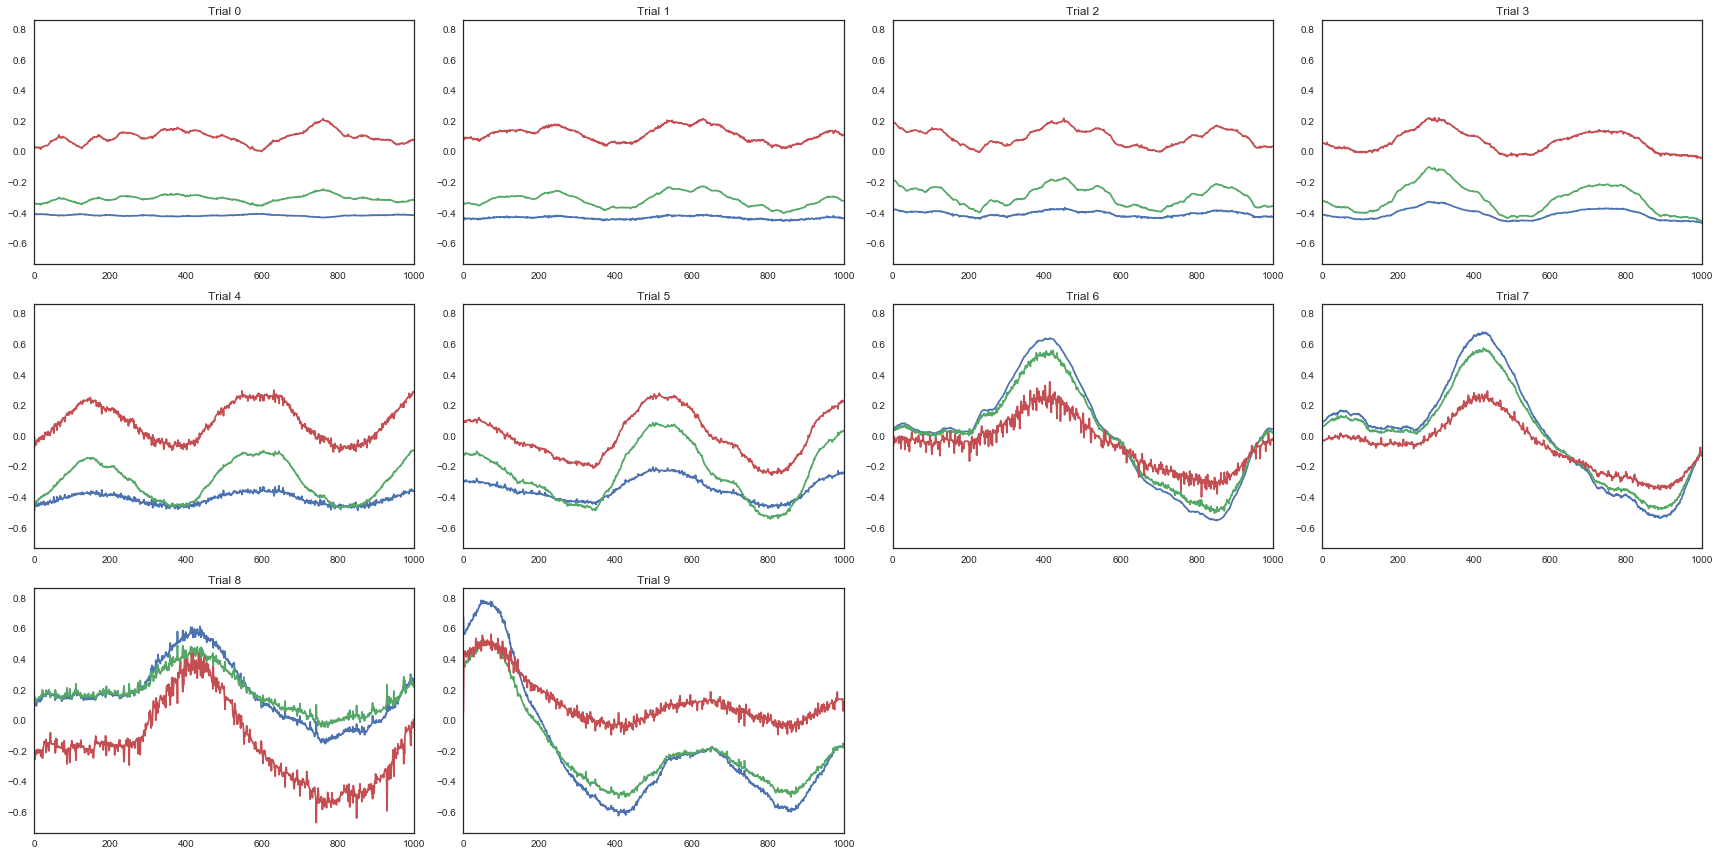

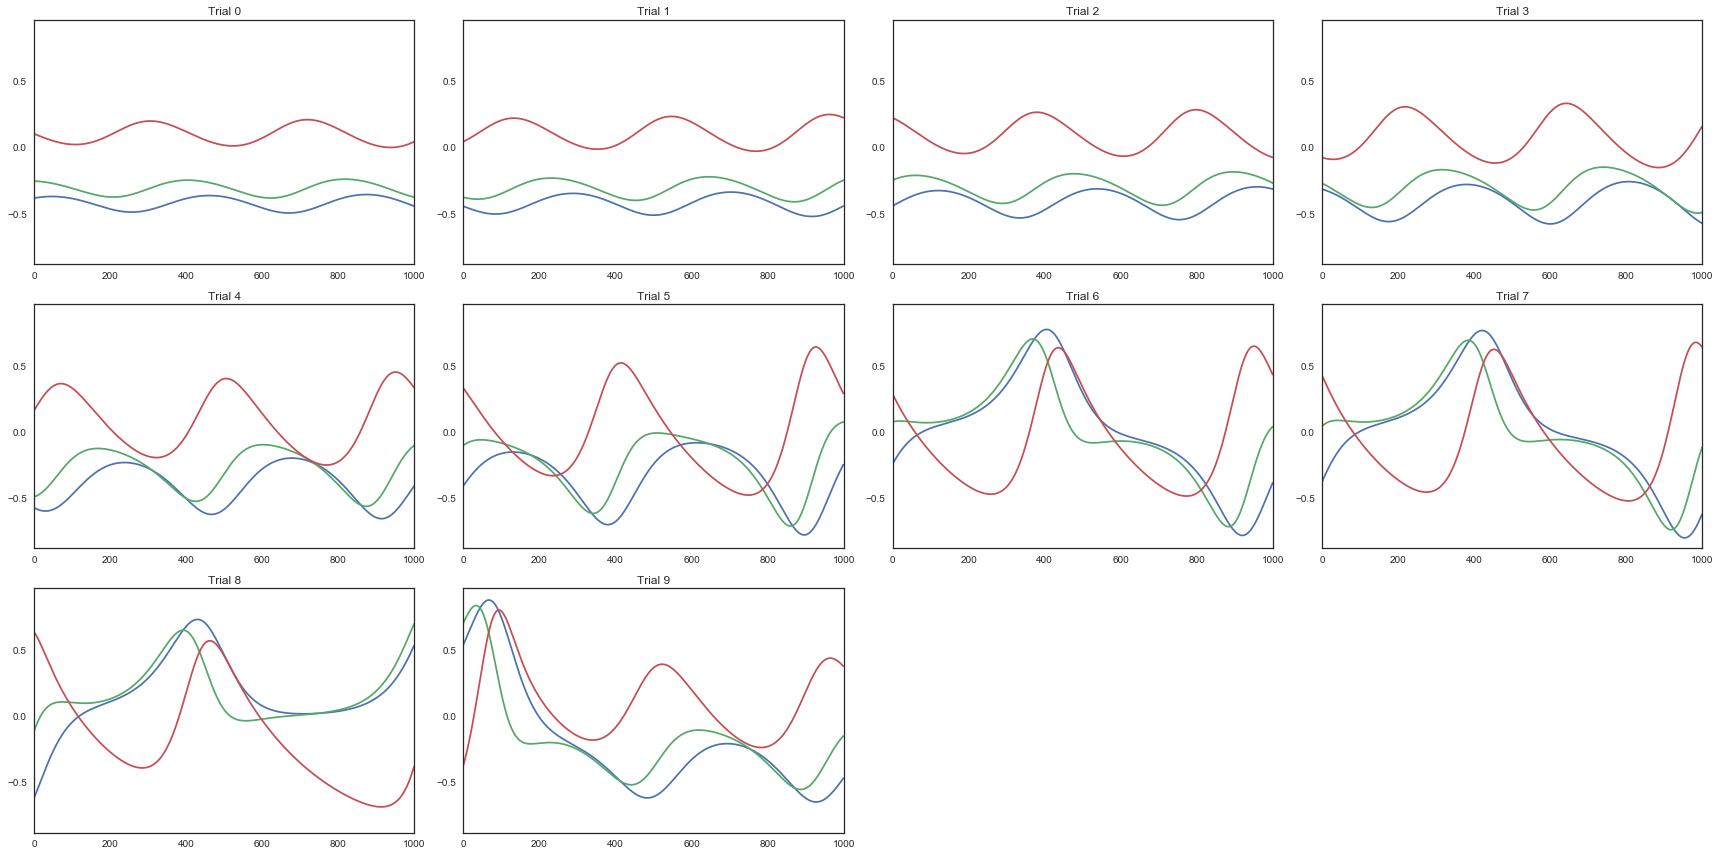

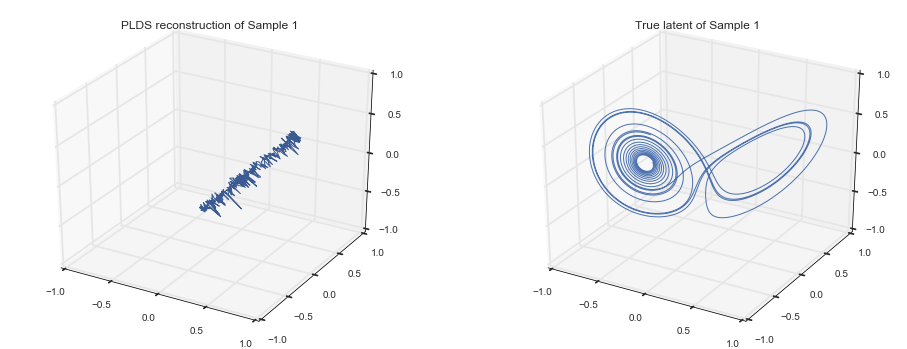

In [1351]:
idx = np.nanargmin(np.array([r['latentAngle'][-1] for r in Lorenz_PLDS]))
print('Sample {}'.format(idx + 1))
bestPLDS = Lorenz_PLDS[idx]
print('Latent subspace angle: {:.2f} deg'.format(rad2deg(bestPLDS['latentAngle'][-1])))
print('Loading subspace angle: {:.2f} deg'.format(rad2deg(bestPLDS['loadingAngle'][-1])))

bestmu = np.rollaxis(bestPLDS['xsm'], axis=-1).transpose((0, 2, 1))
bestx = np.rollaxis(np.dstack(bestPLDS['seq']['x']), axis=-1).transpose((0, 2, 1))
rotated = np.empty_like(bestmu)

for i in range(ntrial):
    rotated[i, :] = util.rotate(util.add_constant(bestmu[i, :]), bestx[i, :])

# rotated = util.align(rotated)
print(rad2deg(subspace(rotated.reshape((-1, nlatent)), bestx.reshape((-1, nlatent)))))
graph.dynplot(rotated.reshape((ntrial, -1, nlatent)))
graph.dynplot(bestx)

fig, ax = plt.subplots(1, 2, figsize=(16, 6), subplot_kw=dict(projection='3d'))
recon = rotated.reshape((-1, nlatent))
# for m in range(ntrial):
ax[0].plot(rotated[8, :, 0], rotated[8, :, 1], rotated[8, :, 2], lw=1, color=vLGPcolor);

# ax[0].plot(recon[:, 0], recon[:, 1], recon[:, 2], lw=1);
ax[0].set_xlim3d(-1, 1);
ax[0].set_ylim3d(-1, 1);
ax[0].set_zlim3d(-1, 1);

ax[0].set_title('PLDS reconstruction of Sample {}'.format(idx + 1));
ax[1].plot(bestx.reshape((-1, nlatent))[:, 0], bestx.reshape((-1, nlatent))[:, 1], bestx.reshape((-1, nlatent))[:, 2], lw=1);
ax[1].set_xlim3d(-1, 1);
ax[1].set_ylim3d(-1, 1);
ax[1].set_zlim3d(-1, 1);
ax[1].set_title('True latent of Sample {}'.format(idx + 1));

/Users/yuan/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


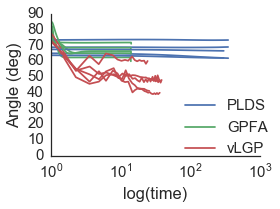

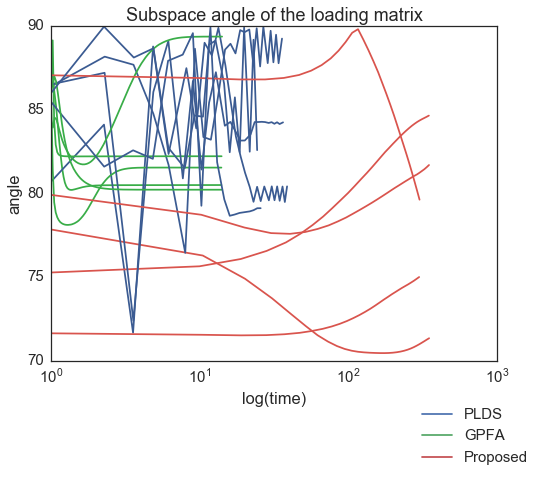

In [1480]:
c0 = list(mpl.rcParams['axes.prop_cycle'])[0]['color']
c1 = list(mpl.rcParams['axes.prop_cycle'])[1]['color']
c2 = list(mpl.rcParams['axes.prop_cycle'])[2]['color']
sns.set(font_scale=1.5)
sns.set_style("white")
plt.figure(figsize=(4, 3));
for i in range(nsample):
    Lorenz_PLDS[i]['Time'][0] = 1
    Lorenz_GPFA[i]['iterTime'][0] = 1
    Lorenz_vLGP[i]['Elapsed'][0, :] = 1
    plt.semilogx(np.cumsum(Lorenz_PLDS[i]['Time']), rad2deg(Lorenz_PLDS[i]['latentAngle'][1:]), color=c0);
    plt.semilogx(np.cumsum(Lorenz_GPFA[i]['iterTime']), rad2deg(Lorenz_GPFA[i]['latentAngle']), color=c1);
    plt.semilogx(np.cumsum(Lorenz_vLGP[i]['Elapsed'][:,2]), rad2deg(Lorenz_vLGP[i]['LatentAngle']), color=c2);
plt.xlabel('log(time)');
plt.ylabel('Angle (deg)');
sns.despine(top=True, right=True)
# plt.title('Subspace angle of the latent dynamics');
plt.ylim([0, 90]);
PLDSline = Line2D((0, 0), (1, 1), color=c0);
GPFAline = Line2D((0, 0), (1, 1), color=c1);
vLGPline = Line2D((0, 0), (1, 1), color=c2);
plt.legend(handles=[PLDSline, GPFAline, vLGPline], labels=['PLDS', 'GPFA', 'vLGP'], loc='lower right', bbox_to_anchor=(1.1, -0.1));
plt.tight_layout()
plt.savefig(os.path.join(figurepath, 'latent_angle_of_lorenz.pdf'))

plt.figure(figsize=(8, 6));
for i in range(nsample):
    Lorenz_PLDS[i]['Time'][0] = 1
    Lorenz_GPFA[i]['iterTime'][0] = 1
    Lorenz_vLGP[i]['Elapsed'][0, :] = 1
    plt.semilogx(np.cumsum(Lorenz_PLDS[i]['Time']), rad2deg(Lorenz_PLDS[i]['loadingAngle']), color=PLDScolor);
    plt.semilogx(np.cumsum(Lorenz_GPFA[i]['iterTime']), rad2deg(Lorenz_GPFA[i]['loadingAngle']), color=GPFAcolor);
    plt.semilogx(np.cumsum(Lorenz_vLGP[i]['Elapsed'][:,2]), rad2deg(Lorenz_vLGP[i]['LoadingAngle']), color=vLGPcolor);
plt.xlabel('log(time)');
plt.ylabel('angle');
plt.title('Subspace angle of the loading matrix');
plt.legend(handles=[PLDSline, GPFAline, vLGPline], labels=['PLDS', 'GPFA', 'Proposed'], bbox_to_anchor=(1.1, -0.1));

In [10]:
LorenzCV_vLGP = [loadmat('{}/lorenz_{}_vLGP_pred'.format(outputpath, i + 1), squeeze_me=True) for i in range(nsample)]
LorenzCV_PLDS = [loadmat('{}/lorenz_{}_PLDS_pred'.format(outputpath, i + 1), squeeze_me=True) for i in range(nsample)]
LorenzCV_GPFA = [loadmat('{}/lorenz_{}_GPFA_pred'.format(outputpath, i + 1), squeeze_me=True) for i in range(nsample)]

## firing rate MSE

In [1018]:
mse = 0.0
for i in range(5):
    mse += np.mean((rate[i, :].ravel() - LorenzCV_vLGP[i]['yhat'].ravel()) ** 2)
print(mse)

0.00205215164034


In [1019]:
mse = 0.0
for i in range(5):
    mse += np.mean((rate[i, :].ravel() - LorenzCV_PLDS[i]['yhat'].ravel()) ** 2)
print(mse)

0.00257784735211


In [1020]:
mse = 0.0
for i in range(5):
    mse += np.mean((rate[i, :].ravel() - LorenzCV_GPFA[i]['yhat'].ravel()) ** 2)
print(mse)

0.00525039059987


In [1021]:
mse = 0.0
for i in range(5):
    mse += np.mean((rate[i, :].ravel() - LorenzCV_GPFA[i]['yhat'].ravel() ** 2) ** 2)
print(mse)

0.00576129368134


## dif

Ttest_1sampResult(statistic=18.159655877600454, pvalue=1.1375058535183019e-73)
Ttest_1sampResult(statistic=-3.8111272887408396, pvalue=0.00013835106640344659)
Ttest_1sampResult(statistic=-17.035566976066214, pvalue=4.667544793431962e-65)
Ttest_1sampResult(statistic=1.7703237110654328, pvalue=0.076673839562200974)
Ttest_1sampResult(statistic=15.883764049353367, pvalue=8.4775664155034842e-57)


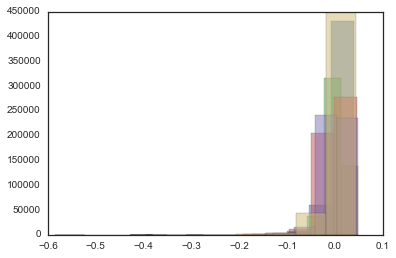

In [1073]:
for i in range(5):
    diff = mu[i, :] - LorenzCV_vLGP[i]['yhat']
    plt.hist(diff.ravel(), alpha=0.5);
    print(stats.ttest_1samp(diff.ravel(), 0))

Ttest_1sampResult(statistic=1256.3945162959353, pvalue=0.0)
Ttest_1sampResult(statistic=1061.0099257003769, pvalue=0.0)
Ttest_1sampResult(statistic=1218.9886782071205, pvalue=0.0)
Ttest_1sampResult(statistic=1236.2260167629099, pvalue=0.0)
Ttest_1sampResult(statistic=1441.9273689339009, pvalue=0.0)


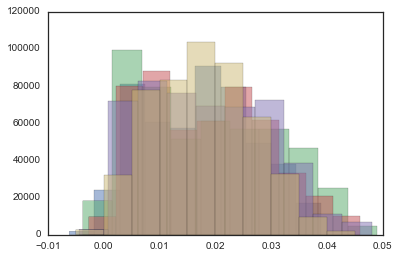

In [1072]:
for i in range(5):
    diff = mu[i, :] - LorenzCV_GPFA[i]['yhat']
    plt.hist(diff.ravel(), alpha=0.5);
    print(stats.ttest_1samp(diff.ravel(), 0))

Ttest_1sampResult(statistic=60.585674812269303, pvalue=0.0)
Ttest_1sampResult(statistic=46.402888037479812, pvalue=0.0)
Ttest_1sampResult(statistic=44.331853854954602, pvalue=0.0)
Ttest_1sampResult(statistic=40.345978144822077, pvalue=0.0)
Ttest_1sampResult(statistic=43.790400916656566, pvalue=0.0)


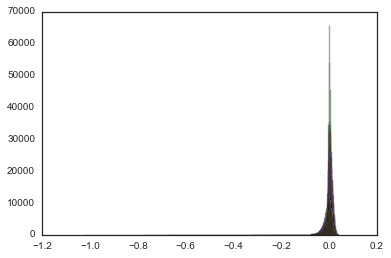

In [1090]:
for i in range(5):
    diff = mu[i, :] - LorenzCV_PLDS[i]['yhat']
    plt.hist(diff.ravel(), alpha=0.5, bins=500);
    print(stats.ttest_1samp(diff.ravel(), 0))

Ttest_1sampResult(statistic=-50.319450466248753, pvalue=0.0)
Ttest_1sampResult(statistic=-2.631781330901517, pvalue=0.0084941119204268098)
Ttest_1sampResult(statistic=-1.6217017332222932, pvalue=0.10486785804959606)
Ttest_1sampResult(statistic=3.4904761780744855, pvalue=0.000482202114747796)
Ttest_1sampResult(statistic=-21.69636407838582, pvalue=2.4815627200511998e-104)


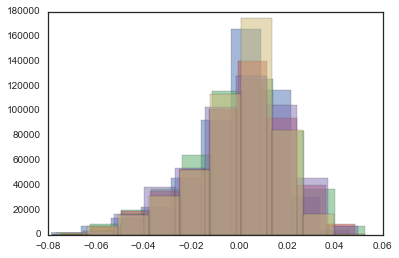

In [1075]:
for i in range(5):
    diff = mu[i, :] - LorenzCV_GPFA[i]['yhat']
    plt.hist(diff.ravel(), alpha=0.5);
    print(stats.ttest_1samp(diff.ravel(), 0))

Ttest_1sampResult(statistic=-58.680457104522688, pvalue=0.0)
Ttest_1sampResult(statistic=-9.5978920281673261, pvalue=8.1950484944601162e-22)
Ttest_1sampResult(statistic=-8.9004956491336937, pvalue=5.5776949507717062e-19)
Ttest_1sampResult(statistic=-3.6448776828047422, pvalue=0.00026754608646852512)
Ttest_1sampResult(statistic=-29.765853213604544, pvalue=1.6018293734374606e-194)


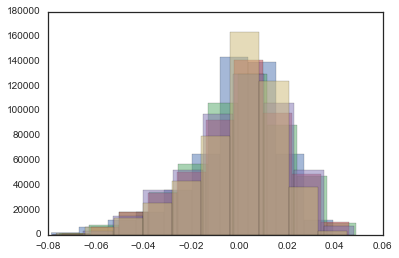

In [1078]:
for i in range(5):
    diff = mu[i, :] - np.abs(LorenzCV_GPFA[i]['yhat'])
    plt.hist(diff.ravel(), alpha=0.5);
    print(stats.ttest_1samp(diff.ravel(), 0))

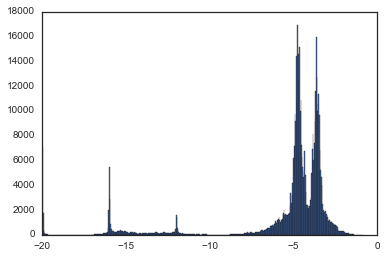

In [1089]:
plt.hist(np.log(LorenzCV_vLGP[0]['yhat'].ravel()), bins=500);

/Users/yuan/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


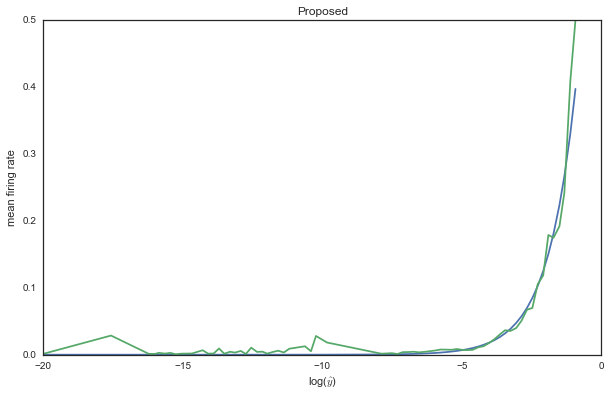

In [1231]:
nbin = 100
logmu = np.log(LorenzCV_vLGP[0]['yhat']).ravel()
bins = np.linspace(start=logmu.min(), stop=logmu.max(), num=nbin)
inds = np.digitize(logmu, bins)
cnt = np.zeros(nbin, dtype=float)
fr = np.zeros(nbin, dtype=float)
pr = np.zeros(nbin, dtype=float)
for i in range(nbin):
    cnt[i] = ((LorenzCV_vLGP[0]['y'].ravel())[inds == i + 1]).sum()
    fr[i] = ((LorenzCV_vLGP[0]['y'].ravel())[inds == i + 1]).mean()
    pr[i] = (np.log(LorenzCV_vLGP[0]['yhat'].ravel())[inds == i + 1]).mean()
plt.figure(figsize=(10, 6))

plt.plot(pr[fr > 0], np.exp(pr[fr > 0]));
plt.plot(pr[fr > 0], fr[fr > 0]);
plt.title('Proposed');
plt.xlabel(r'log($\hat{y}$)');
plt.ylabel(r'mean firing rate');

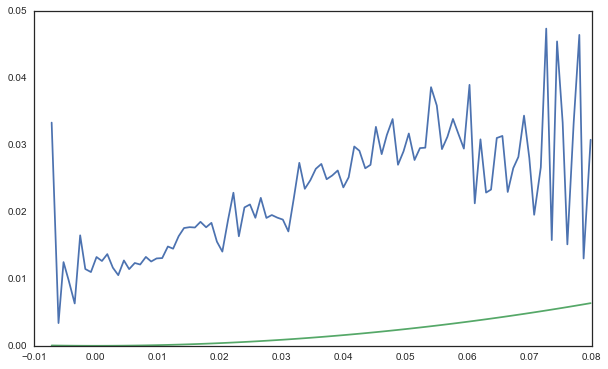

In [1236]:
logmu = LorenzCV_GPFA[0]['yhat'].ravel()
bins = np.linspace(start=logmu.min(), stop=logmu.max(), num=nbin)
inds = np.digitize(logmu, bins)
fr = np.zeros(nbin, dtype=float)
pr = np.zeros(nbin, dtype=float)
for i in range(nbin):
    fr[i] = ((LorenzCV_vLGP[0]['y'].ravel())[inds == i + 1]).mean()
    pr[i] = (LorenzCV_GPFA[0]['yhat'].ravel()[inds == i + 1]).mean()
plt.figure(figsize=(10, 6))
plt.plot(pr[fr > 0], fr[fr > 0]);
plt.plot(pr[fr > 0], pr[fr > 0]**2);

/Users/yuan/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


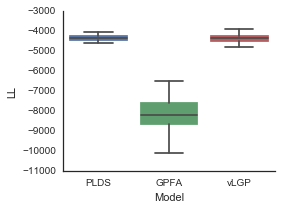

In [13]:
nsample = 5
ntrial = 10
LL = np.zeros((nsample, ntrial, 3))
sns.set_style("white")
for i in range(nsample):
    LL[i, :, 2] = np.nansum(stats.poisson.logpmf(LorenzCV_vLGP[i]['y'], LorenzCV_vLGP[i]['yhat']), axis=(1, 2))
    LL[i, :, 1] = np.nansum(stats.poisson.logpmf(LorenzCV_vLGP[i]['y'], LorenzCV_GPFA[i]['yhat']**2), axis=(1, 2))
    LL[i, :, 0] = np.nansum(stats.poisson.logpmf(LorenzCV_vLGP[i]['y'], LorenzCV_PLDS[i]['yhat']), axis=(1, 2))
plt.figure(figsize=(4, 3));
ax = sns.boxplot(data=pd.DataFrame(LL.reshape((-1, 3)), columns=['PLDS', 'GPFA', 'vLGP']), showfliers=False);
plt.xlabel('Model');
plt.ylabel('LL')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# plt.title('Prediction Log-Likelihood');
plt.tight_layout()
# plt.savefig(os.path.join(figurepath, 'prediction_ll_lorenz.pdf'))
# locs, labels = plt.xticks();
# plt.xticks(locs, ['PLDS', 'GPFA', 'Proposed']);

In [1355]:
idx = 2
itrial = 1
refy = Lorenz_vLGP[idx]['y'][itrial, :]
refx = Lorenz_vLGP[idx]['x'][itrial, :]
vLGP = Lorenz_vLGP[idx]['mu']
GPFA = np.rollaxis(np.dstack(Lorenz_GPFA[idx]['seqTrain']['xsm']), axis=-1).transpose((0, 2, 1))
PLDS = np.rollaxis(Lorenz_PLDS[idx]['xsm'], axis=-1).transpose((0, 2, 1))

rotvLGP = util.rotate(util.add_constant(vLGP[itrial, :]), refx)
rotGPFA = util.rotate(util.add_constant(GPFA[itrial, :]), refx)
rotPLDS = util.rotate(util.add_constant(PLDS[itrial, :]), refx)

print(mathf.subspace(rotPLDS, refx))
print(mathf.subspace(rotGPFA, refx))
print(mathf.subspace(rotvLGP, refx))

1.41577880485
0.645451531622
0.46814201935


/Users/yuan/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


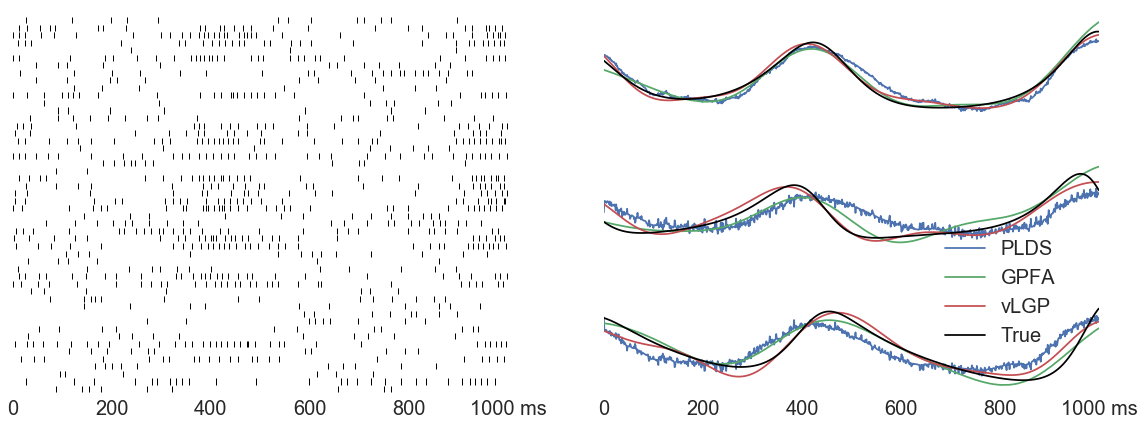

In [1479]:
sns.set(font_scale=2)
sns.set_style("white")
plt.figure(figsize=(16, 6))
ax = plt.subplot2grid((3, 2), (0, 0), rowspan=3)
ntrain = 50
plt.ylim(0, ntrain);
for i, n in enumerate(np.random.permutation(np.arange(ntrain))):
    plt.vlines(np.arange(ntime)[refy[:, n] > 0], i + 0.1, i + 1 - 0.1, color='black', lw=1);
plt.yticks([]);
plt.xticks([0, 200, 400, 600, 800, 1000], ['0', '200', '400', '600', '800', '1000 ms']);
ax.set_frame_on(False)
ax.get_yaxis().set_visible(False);
ax.invert_yaxis();

for i in range(3):
    ax = plt.subplot2grid((3, 2), (i, 1))
    plt.plot(rotPLDS[:, i], alpha=1, label='PLDS');
    plt.plot(rotGPFA[:, i], alpha=1, label='GPFA');
    plt.plot(rotvLGP[:, i], alpha=1, label='vLGP');
    plt.plot(refx[:, i], label='True', color='k');
    ax.axis('off')
ax.axis('on')
ax.set_frame_on(False)
ax.get_yaxis().set_visible(False);
plt.xticks([0, 200, 400, 600, 800, 1000], ['0', '200', '400', '600', '800', '1000 ms']);
plt.tight_layout()
plt.legend(loc='lower center', bbox_to_anchor=(0.8, 0.3));
plt.savefig(os.path.join(os.path.expanduser("~/variational-doc/figure"), 'spike_and_latent_lorenz.pdf'))

## PLDS.shape

In [1369]:
for i in range(nsample):
    print(np.cumsum(Lorenz_PLDS[i]['Time'])[-1])
    print(np.cumsum(Lorenz_GPFA[i]['iterTime'])[-1])
    print(np.cumsum(Lorenz_vLGP[i]['Elapsed'][:,2])[-1])

for i in range(nsample):
    print(Lorenz_PLDS[i]['Time'].shape)
    print(Lorenz_GPFA[i]['iterTime'].shape)
    print(Lorenz_vLGP[i]['Elapsed'][:,2].shape)

347.96
13.972841424
38.6206156141
346.51
13.978869949
35.710824081
298.13
14.025509352
36.2881294959
347.27
14.12612393
24.3073671318
299.93
14.053450806
25.6649648098


In [1417]:
lastangle = np.empty((nsample, 3))
for i in range(nsample):
    lastangle[i, 0] = rad2deg(Lorenz_PLDS[i]['latentAngle'][-1])
    lastangle[i, 1] = rad2deg(Lorenz_GPFA[i]['latentAngle'][-1])
    lastangle[i, 2] = rad2deg(Lorenz_vLGP[i]['LatentAngle'][-1]);

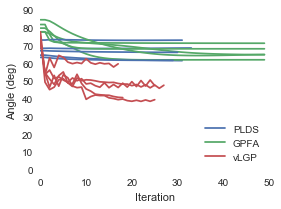

In [1442]:
c0 = list(mpl.rcParams['axes.prop_cycle'])[0]['color']
c1 = list(mpl.rcParams['axes.prop_cycle'])[1]['color']
c2 = list(mpl.rcParams['axes.prop_cycle'])[2]['color']

plt.figure(figsize=(4, 3));
for i in range(nsample):
    Lorenz_GPFA[i]['latentAngle'][0] = Lorenz_GPFA[i]['latentAngle'][1]
    plt.plot(rad2deg(Lorenz_PLDS[i]['latentAngle']), color=c0);
    plt.plot(rad2deg(Lorenz_GPFA[i]['latentAngle'][:50]), color=c1);
    plt.plot(rad2deg(Lorenz_vLGP[i]['LatentAngle']), color=c2);
plt.xlabel('Iteration');
plt.ylabel('Angle (deg)');
plt.gca().set_frame_on(False);
# plt.title('Subspace angle of the latent dynamics');
plt.ylim([0, 90]);
PLDSline = Line2D((0, 0), (1, 1), color=c0);
GPFAline = Line2D((0, 0), (1, 1), color=c1);
vLGPline = Line2D((0, 0), (1, 1), color=c2);
plt.legend(handles=[PLDSline, GPFAline, vLGPline], labels=['PLDS', 'GPFA', 'vLGP'], loc='lower right');
plt.tight_layout()
plt.savefig(os.path.join(figurepath, 'latent_angle_vs_iter_lorenz.pdf'))

In [72]:
LorenzCV_vLGP = [loadmat('{}/lorenz_{}_vLGP_pred_1ms'.format(outputpath, i + 1), squeeze_me=True) for i in range(nsample)]
LorenzCV_PLDS = [loadmat('{}/lorenz_{}_PLDS_pred'.format(outputpath, i + 1), squeeze_me=True) for i in range(nsample)]
LorenzCV_GPFA = [loadmat('{}/lorenz_{}_GPFA_pred'.format(outputpath, i + 1), squeeze_me=True) for i in range(nsample)]

In [134]:
LL = np.zeros((nsample, ntrial, 3))
y = np.zeros((nsample, ntrial, ntime, nspike), dtype=float)
for i in range(nsample):
    LL[i, :, 2] = np.nansum(stats.poisson.logpmf(LorenzCV_vLGP[i]['y'], LorenzCV_vLGP[i]['yhat']), axis=(1, 2))
    LL[i, :, 1] = np.nansum(stats.poisson.logpmf(LorenzCV_vLGP[i]['y'], LorenzCV_GPFA[i]['yhat']**2), axis=(1, 2))
    LL[i, :, 0] = np.nansum(stats.poisson.logpmf(LorenzCV_vLGP[i]['y'], LorenzCV_PLDS[i]['yhat']), axis=(1, 2))
    y[i, :] = LorenzCV_vLGP[i]['y']

In [135]:
nullyhat = np.repeat(y.mean(axis=2), ntime, axis=2).reshape((nsample, ntrial, ntime, nspike))
nullLL = np.nansum(stats.poisson.logpmf(y, nullyhat), axis=(2, 3))

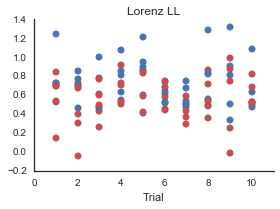

In [136]:
plt.figure(figsize=(4, 3));
for i in range(nsample):
    plt.plot(np.arange(ntrial) + 1, (LL[i, :, 0] - nullLL[i, :]) / ntime / np.log(2), ls='', marker='o', color=c0, label='PLDS');
#     plt.plot(np.arange(ntrial) + 1, (LL[i, :, 1] - nullLL[i, :]) / ntime / np.log(2), ls='', marker='o', color=c1, label='GPFA');
    plt.plot(np.arange(ntrial) + 1, (LL[i, :, 2] - nullLL[i, :]) / ntime / np.log(2), ls='', marker='o', color=c2, label='vLGP');
sns.despine(right=True, top=True)
plt.xlim([0, 11]);
plt.xlabel('Trial');
plt.title('Lorenz LL');
# plt.legend(loc='upper right');
plt.tight_layout();
plt.savefig(os.path.join(figurepath, 'lorenz_ll_scatter.pdf'))

/Users/yuan/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


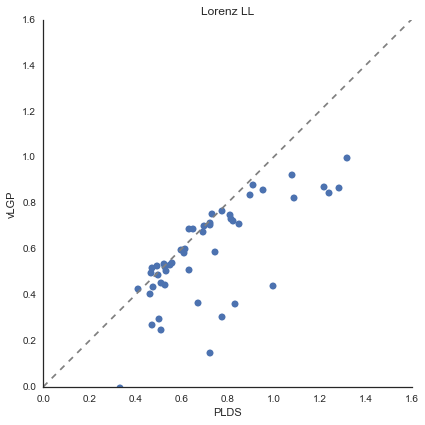

In [137]:
sns.set(font_scale=1);
sns.set_style("white");

# nullyhat = np.repeat(y.mean(axis=1), ntime, axis=1).reshape((ntrial, ntime, nspike))
# nullLL = np.nansum(stats.poisson.logpmf(y, nullyhat), axis=(1, 2))
plt.figure(figsize=(6, 6));
plt.plot((LL[:, :, 0].ravel() - nullLL.ravel()) / ntime / np.log(2), (LL[:, :, 2].ravel() - nullLL.ravel()) / ntime / np.log(2), ls='', marker='o');
sns.despine(right=True, top=True);
# plt.axes().set_aspect('equal', 'datalim');
plt.xlabel('PLDS');
plt.ylabel('vLGP');
plt.xlim([0, 1.6]);
plt.ylim([0, 1.6]);
plt.title('Lorenz LL');
# plt.legend(loc='upper right');
plt.tight_layout();
plt.plot([0, 2], [0,2], ls='--', c='gray');
# plt.savefig(os.path.join(figurepath, 'lorenz_ll_scatter.pdf'))

In [138]:
# cv
np.random.seed(0)
fLorenzSample = ['{}/lorenz_{}'.format(samplepath, i + 1) for i in range(nsample)]
LorenzCV_vLGP = []

for i, fname in enumerate(fLorenzSample):
    print('Sample {}'.format(i + 1))
    sigma = np.full(nlatent, fill_value=1.0)
    omega = np.full(nlatent, fill_value=1e-5)
    sample = loadmat(fname, squeeze_me=True)
    result = vlgp.cv(sample['y'], ['spike'] * sample['y'].shape[-1], sigma, omega, lag=1, rank=100, nadjhess=1000,
                                   niter=200, tol=1e-6, learn_omega=True, loading = 'GA')
#     savemat('{}/lorenz_{}_vLGP_pred_1ms'.format(outputpath, i + 1), result)
    LorenzCV_vLGP.append(result)
print('Done.')

Sample 1
Sample 2
Sample 3
Sample 4
Sample 5
Done.


In [154]:
np.random.seed(0)
Lorenz_vLGP = []
for i, fname in enumerate(fLorenzSample):
    print('Sample {}'.format(i + 1))
    sigma = np.full(nlatent, fill_value=1.0)
    omega = np.full(nlatent, fill_value=1e-5)
    sample = loadmat(fname, squeeze_me=True)
#     fitted = vlgp.fitparam(sample['y'], ['spike'] * sample['y'].shape[-1], sigma, omega, x=sample['x'], 
#                                    alpha=sample['alpha'], beta=sample['beta'], lag=1, rank=100, nadjhess=1000,
#                                    niter=500, tol=1e-6, verbose=False, learn_omega=False, loading='GA')
    fitted = vlgp.fit(sample['y'], ['spike'] * sample['y'].shape[-1], sigma, omega, x=sample['x'], 
                                   alpha=sample['alpha'], beta=sample['beta'], lag=1, rank=100, nadjhess=1000,
                                   niter=500, tol=1e-5, verbose=False, learn_omega=True)
    Lorenz_vLGP.append(fitted)
print('Done.')

Sample 1
Sample 2
Sample 3
Sample 4
Sample 5
Done.


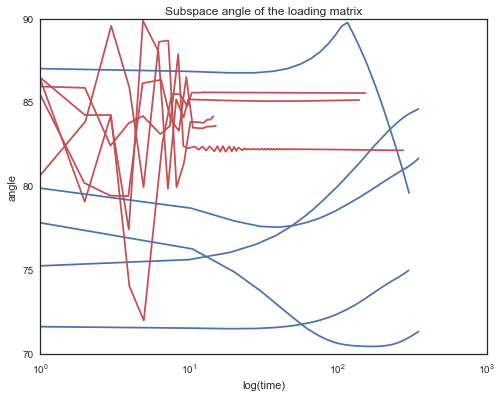

In [155]:
plt.figure(figsize=(8, 6));
for i in range(nsample):
    Lorenz_PLDS[i]['Time'][0] = 1
#     Lorenz_GPFA[i]['iterTime'][0] = 1
    Lorenz_vLGP[i]['Elapsed'][0, :] = 1
    plt.semilogx(np.cumsum(Lorenz_PLDS[i]['Time']), rad2deg(Lorenz_PLDS[i]['loadingAngle']), color=c0);
#     plt.semilogx(np.cumsum(Lorenz_GPFA[i]['iterTime']), rad2deg(Lorenz_GPFA[i]['loadingAngle']), color=GPFAcolor);
    plt.semilogx(np.cumsum(Lorenz_vLGP[i]['Elapsed'][:,2]), rad2deg(Lorenz_vLGP[i]['LoadingAngle']), color=c2);
plt.xlabel('log(time)');
plt.ylabel('angle');
plt.title('Subspace angle of the loading matrix');

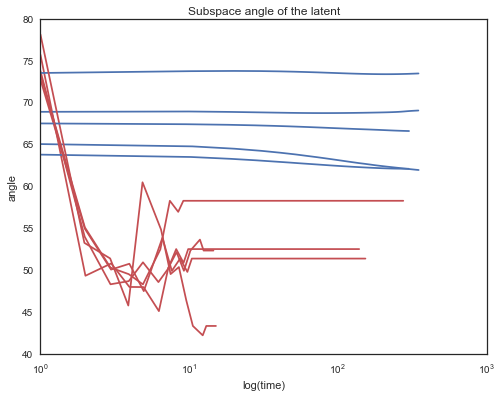

In [156]:
plt.figure(figsize=(8, 6));
for i in range(nsample):
    Lorenz_PLDS[i]['Time'][0] = 1
#     Lorenz_GPFA[i]['iterTime'][0] = 1
    Lorenz_vLGP[i]['Elapsed'][0, :] = 1
    plt.semilogx(np.cumsum(Lorenz_PLDS[i]['Time']), rad2deg(Lorenz_PLDS[i]['latentAngle'][1:]), color=c0);
#     plt.semilogx(np.cumsum(Lorenz_GPFA[i]['iterTime']), rad2deg(Lorenz_GPFA[i]['loadingAngle']), color=GPFAcolor);
    plt.semilogx(np.cumsum(Lorenz_vLGP[i]['Elapsed'][:,2]), rad2deg(Lorenz_vLGP[i]['LatentAngle']), color=c2);
plt.xlabel('log(time)');
plt.ylabel('angle');
plt.title('Subspace angle of the latent');

In [97]:
fitted['mu'] = sample['x']

In [125]:
fitted = vlgp.fitparam(sample['y'], ['spike'] * sample['y'].shape[-1], sigma, omega, x=sample['x'], 
                               alpha=sample['alpha'], beta=sample['beta'], lag=1, rank=100, nadjhess=100,
                               niter=100, tol=1e-5, verbose=True, learn_omega=False, loading='GA')


Inference starts

[1]
sigma: [ 1.  1.  1.]
ELBO: -279867.72864072246
Elapsed Total: 0.7161125420243479
Elapsed Post: 5.769543349742889e-07
omega: [  1.00000000e-05   1.00000000e-05   1.00000000e-05]
Elapsed Param: 0.5909685639780946
LL: -225225.00379817066

[2]
sigma: [ 1.  1.  1.]
ELBO: -143192.74172415127
Elapsed Total: 0.7169425939791836
Elapsed Post: 5.760230123996735e-07
omega: [  1.00000000e-05   1.00000000e-05   1.00000000e-05]
Elapsed Param: 0.5969628810416907
LL: -88550.01688159943

[3]
sigma: [ 1.  1.  1.]
ELBO: -110226.35074601037
Elapsed Total: 0.7205716469907202
Elapsed Post: 7.839989848434925e-07
omega: [  1.00000000e-05   1.00000000e-05   1.00000000e-05]
Elapsed Param: 0.6009196529630572
LL: -55583.6259034585

[4]
sigma: [ 1.  1.  1.]
ELBO: -101661.86657822882
Elapsed Total: 0.7168492759810761
Elapsed Post: 7.160124368965626e-07
omega: [  1.00000000e-05   1.00000000e-05   1.00000000e-05]
Elapsed Param: 0.6003132589976303
LL: -47019.14173567695

[5]
sigma: [ 1.  1.  1.]


In [314]:
np.random.seed(0)
low = np.log(15 / ntime)
aspk = np.sort((np.random.rand(nlatent, nspike) + 1) * np.sign(np.random.randn(nlatent, nspike)), axis=1)
bspk = np.vstack((low * np.ones(nspike), -10 * np.ones(nspike), -10 * np.ones(nspike), -3 * np.ones(nspike), 
                  -3 * np.ones(nspike), -3 * np.ones(nspike), -3 * np.ones(nspike), -2 * np.ones(nspike),
                  -2 * np.ones(nspike), -1 * np.ones(nspike), -1 * np.ones(nspike)))
fr = np.empty((5, 10, 1000, 50), dtype=float)
for i in range(5):
    x, _ = simulation.gp(np.array([5e-4, 1e-4, 5e-5]), 10000, 1)
    x = x.reshape((10, 1000, 3))
    y, _, fr[i, :] = simulation.spike(x, aspk, bspk)
    
    fname = os.path.join(samplepath, 'GP_{}'.format(i + 1))
#     savemat(fname, {'y': y, 'x': x, 'alpha': aspk, 'beta': bspk})    

In [280]:
np.random.seed(0)
GP_vLGP = []
for i in range(5):
    fname = os.path.join(samplepath, 'GP_{}'.format(i + 1))
    print(fname)
    sigma = np.full(nlatent, fill_value=1.0)
    omega = np.array([5e-4, 1e-4, 5e-5])
    sample = loadmat(fname, squeeze_me=True)
    init = loadmat(os.path.join(outputpath, 'GP_{}_NN'.format(i + 1)), squeeze_me=True)
    a0 = init['loading'].T
    mu0 = np.zeros((10, 1000, 3), dtype=float)
#     fitted = vlgp.fitparam(sample['y'], ['spike'] * sample['y'].shape[-1], sigma, omega, x=sample['x'], 
#                                    alpha=sample['alpha'], beta=sample['beta'], lag=1, rank=100, nadjhess=1000,
#                                    niter=500, tol=1e-6, verbose=False, learn_omega=False, loading='GA')
    fitted = vlgp.fit(sample['y'], ['spike'] * sample['y'].shape[-1], sigma, omega, x=sample['x'], a0=sample['alpha'], mu0=sample['x'],
                                   alpha=sample['alpha'], beta=sample['beta'], lag=1, rank=100, nadjhess=1000,
                                   niter=100, tol=1e-5, verbose=True, learn_omega=False, moreparam=False)
    GP_vLGP.append(fitted)
print('Done.')

/Users/yuan/data/sample/GP_1

Inference starts

ELBO decreased. Backtracking.

[1]
sigma: [ 1.  1.  1.]
ELBO: -516794.22893904895
Elapsed Total: 1.2160674079786986
Elapsed Post: 0.37602735101245344
omega: [  5.00000000e-04   1.00000000e-04   5.00000000e-05]
Elapsed Param: 0.6576290439697914
LL: -34343969753983.184

Inference ends
1 iterations, ELBO: -516794.2289, elapsed: 1.22, converged: False

/Users/yuan/data/sample/GP_2

Inference starts

ELBO decreased. Backtracking.

[1]
sigma: [ 1.  1.  1.]
ELBO: -514941.7421514451
Elapsed Total: 1.1968921729712747
Elapsed Post: 0.3773402989609167
omega: [  5.00000000e-04   1.00000000e-04   5.00000000e-05]
Elapsed Param: 0.6411076959921047
LL: -16565746920438.848

Inference ends
1 iterations, ELBO: -514941.7422, elapsed: 1.20, converged: False

/Users/yuan/data/sample/GP_3

Inference starts

ELBO decreased. Backtracking.

[1]
sigma: [ 1.  1.  1.]
ELBO: -515063.1908203118
Elapsed Total: 1.1933289060252719
Elapsed Post: 0.37423534598201513
omega: 

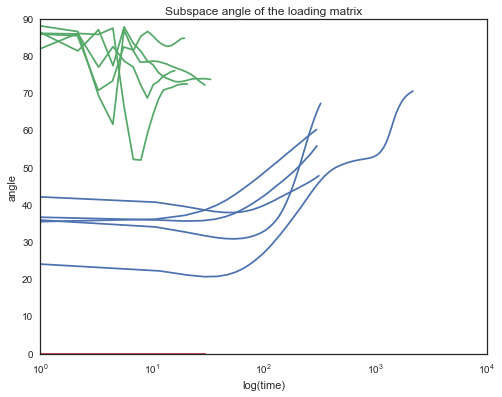

In [323]:
plt.figure(figsize=(8, 6));
for i in range(5):
    GP_PLDS[i]['Time'][0] = 1
#     Lorenz_GPFA[i]['iterTime'][0] = 1
    GP_vLGP[i]['Elapsed'][0, :] = 1
    GP_vLGP2[i]['Elapsed'][0, :] = 1
    plt.semilogx(np.cumsum(GP_PLDS[i]['Time']), rad2deg(GP_PLDS[i]['loadingAngle']), color=c0);
#     plt.semilogx(np.cumsum(Lorenz_GPFA[i]['iterTime']), rad2deg(Lorenz_GPFA[i]['loadingAngle']), color=GPFAcolor);
    plt.semilogx(np.cumsum(GP_vLGP2[i]['Elapsed'][:,2]), rad2deg(GP_vLGP2[i]['LoadingAngle']), color=c1);
    plt.semilogx(np.cumsum(GP_vLGP[i]['Elapsed'][:,2]), rad2deg(GP_vLGP[i]['LoadingAngle']), color=c2);
plt.xlabel('log(time)');
plt.ylabel('angle');
plt.title('Subspace angle of the loading matrix');

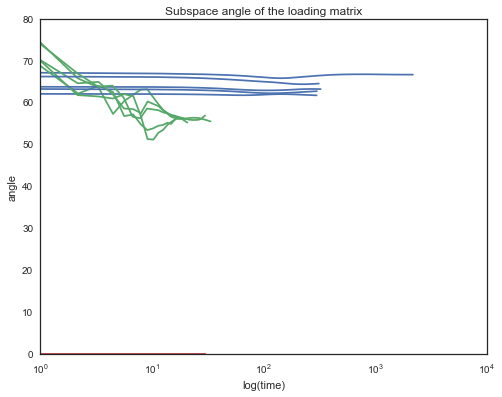

In [324]:
plt.figure(figsize=(8, 6));
for i in range(5):
    GP_PLDS[i]['Time'][0] = 1
#     Lorenz_GPFA[i]['iterTime'][0] = 1
    GP_vLGP[i]['Elapsed'][0, :] = 1
    GP_vLGP2[i]['Elapsed'][0, :] = 1

    plt.semilogx(np.cumsum(GP_PLDS[i]['Time']), rad2deg(GP_PLDS[i]['latentAngle']), color=c0);
#     plt.semilogx(np.cumsum(Lorenz_GPFA[i]['iterTime']), rad2deg(Lorenz_GPFA[i]['loadingAngle']), color=GPFAcolor);
    plt.semilogx(np.cumsum(GP_vLGP2[i]['Elapsed'][:,2]), rad2deg(GP_vLGP2[i]['LatentAngle']), color=c1);
    plt.semilogx(np.cumsum(GP_vLGP[i]['Elapsed'][:,2]), rad2deg(GP_vLGP[i]['LatentAngle']), color=c2);
plt.xlabel('log(time)');
plt.ylabel('angle');
plt.title('Subspace angle of the loading matrix');

In [217]:
np.random.seed(0)
GP_vLGP_CV = []
for i in range(5):
    fname = os.path.join(samplepath, 'GP_{}'.format(i + 1))
    print(fname)
    sigma = np.full(nlatent, fill_value=1.0)
    omega = np.full(nlatent, fill_value=1e-5)
    sample = loadmat(fname, squeeze_me=True)
    cv = vlgp.cv(sample['y'], ['spike'] * sample['y'].shape[-1], sigma, omega, lag=1, rank=100, nadjhess=1000,
                                   niter=100, tol=1e-5, learn_omega=True)
    GP_vLGP_CV.append(cv)
print('Done.')

/Users/yuan/data/sample/GP_1
/Users/yuan/data/sample/GP_2
/Users/yuan/data/sample/GP_3
/Users/yuan/data/sample/GP_4
/Users/yuan/data/sample/GP_5
Done.


In [319]:
GP_PLDS = [loadmat('{}/GP_{}_PLDS'.format(outputpath, i + 1), squeeze_me=True) for i in range(5)]

In [265]:
GP_init = [loadmat(os.path.join(outputpath, 'GP_{}_NN'.format(i + 1)), squeeze_me=True)]

In [268]:
np.transpose(GP_init[0]['latent'], (2,1,0)).shape

(10, 1000, 3)

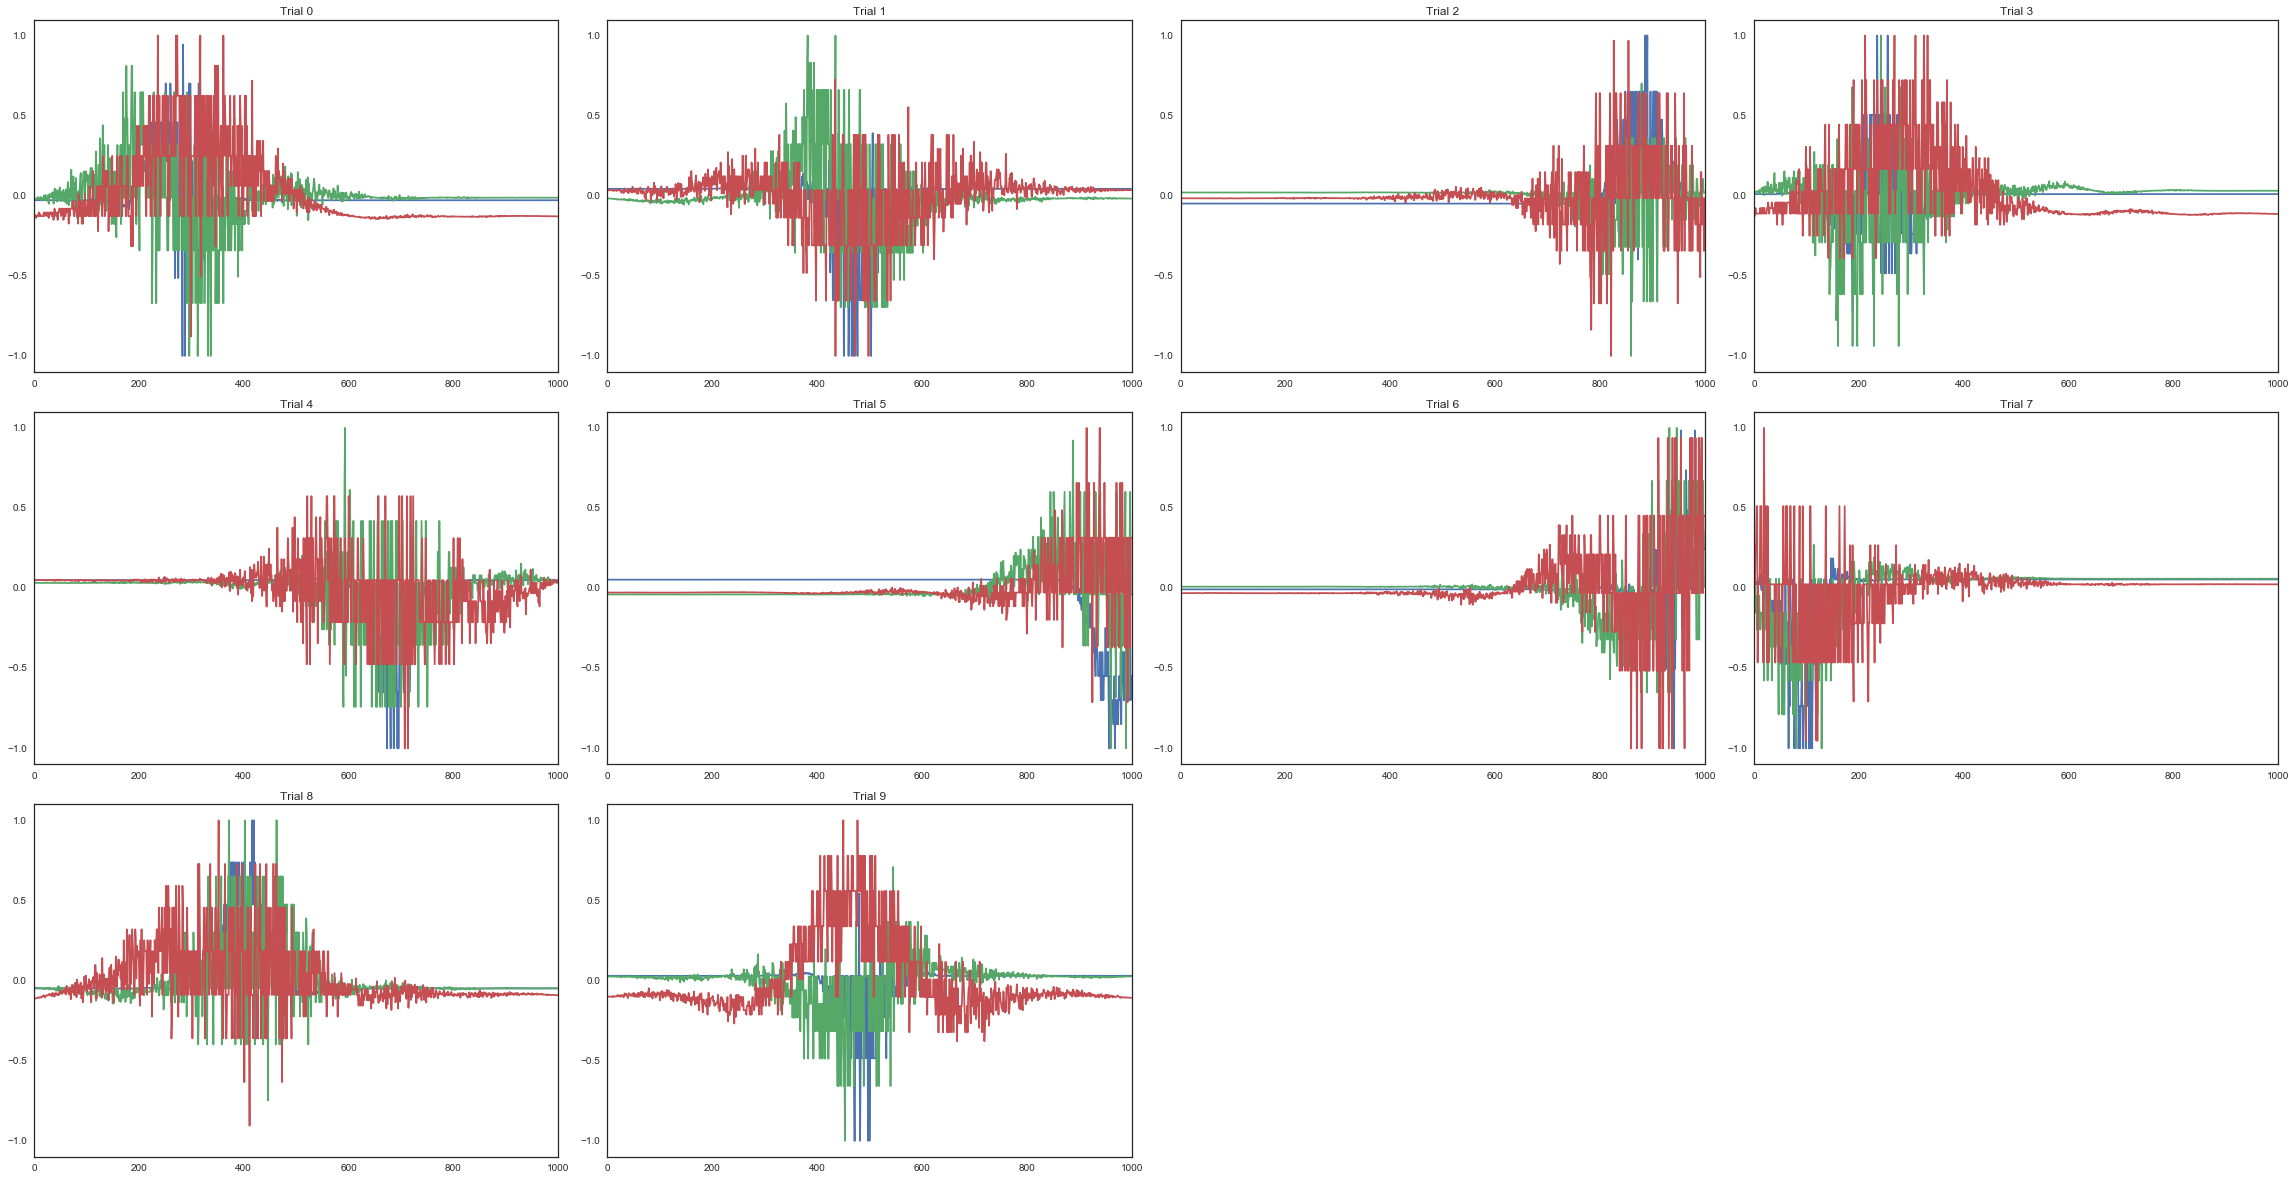

In [279]:
graph.dynplot(fitted['mu'])

In [283]:
GP_PLDS_CV = [loadmat(os.path.join(outputpath, 'GP_{}_PLDS_pred'.format(i + 1)), squeeze_me=True) for i in range(5)] 

In [296]:
LL = np.zeros((nsample, ntrial, 3))
y = np.zeros((nsample, ntrial, ntime, nspike), dtype=float)
for i in range(nsample):
    y[i, :] = GP_vLGP_CV[i]['y']
    LL[i, :, 2] = np.nansum(stats.poisson.logpmf(y[i, :], GP_vLGP_CV[i]['yhat']), axis=(1, 2))
#     LL[i, :, 1] = np.nansum(stats.poisson.logpmf(y[i, :], LorenzCV_GPFA[i]['yhat']**2), axis=(1, 2))
    LL[i, :, 0] = np.nansum(stats.poisson.logpmf(y[i, :], GP_PLDS_CV[i]['yhat']), axis=(1, 2))
nullyhat = np.repeat(y.mean(axis=2), ntime, axis=2).reshape((nsample, ntrial, ntime, nspike))
nullLL = np.nansum(stats.poisson.logpmf(y, nullyhat), axis=(2, 3))

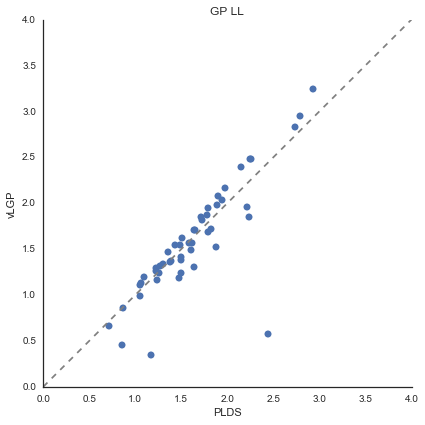

In [297]:
LL = np.zeros((nsample, ntrial, 3))
y = np.zeros((nsample, ntrial, ntime, nspike), dtype=float)
for i in range(nsample):
    y[i, :] = GP_vLGP_CV[i]['y']
    LL[i, :, 2] = np.nansum(stats.poisson.logpmf(y[i, :], GP_vLGP_CV[i]['yhat']), axis=(1, 2))
#     LL[i, :, 1] = np.nansum(stats.poisson.logpmf(y[i, :], LorenzCV_GPFA[i]['yhat']**2), axis=(1, 2))
    LL[i, :, 0] = np.nansum(stats.poisson.logpmf(y[i, :], GP_PLDS_CV[i]['yhat']), axis=(1, 2))
nullyhat = np.repeat(y.mean(axis=2), ntime, axis=2).reshape((nsample, ntrial, ntime, nspike))
nullLL = np.nansum(stats.poisson.logpmf(y, nullyhat), axis=(2, 3))
plt.figure(figsize=(6, 6));
plt.plot((LL[:, :, 0].ravel() - nullLL.ravel()) / ntime / np.log(2), (LL[:, :, 2].ravel() - nullLL.ravel()) / ntime / np.log(2), ls='', marker='o');
sns.despine(right=True, top=True);
# plt.axes().set_aspect('equal', 'datalim');
plt.xlabel('PLDS');
plt.ylabel('vLGP');
plt.xlim([0, 4]);
plt.ylim([0, 4]);
plt.title('GP LL');
# plt.legend(loc='upper right');
plt.tight_layout();
plt.plot([0, 4], [0, 4], ls='--', c='gray');

In [295]:
GP_vLGP_CV = [loadmat(os.path.join(outputpath, 'GP_{}_vLGP_pred'.format(i + 1)), squeeze_me=True) for i in range(5)] 

In [292]:
np.random.seed(0)
GP_vLGP_CV = []
for i in range(5):
    fname = os.path.join(samplepath, 'GP_{}'.format(i + 1))
    print(fname)
    sigma = np.full(nlatent, fill_value=1.0)
    omega = np.full(nlatent, fill_value=1e-5)
    sample = loadmat(fname, squeeze_me=True)
    cv = vlgp.cv(sample['y'], ['spike'] * sample['y'].shape[-1], sigma, omega, lag=1, rank=100, nadjhess=1000,
                                   niter=100, tol=1e-5, learn_omega=True, moreparam=False)
    GP_vLGP_CV.append(cv)
print('Done.')

/Users/yuan/data/sample/GP_1
/Users/yuan/data/sample/GP_2
/Users/yuan/data/sample/GP_3
/Users/yuan/data/sample/GP_4
/Users/yuan/data/sample/GP_5
Done.


In [298]:
np.random.seed(0)
GP_vLGP = []
for i in range(5):
    fname = os.path.join(samplepath, 'GP_{}'.format(i + 1))
    print(fname)
    sigma = np.full(nlatent, fill_value=1.0)
    omega = np.array([5e-4, 1e-4, 5e-5])
    sample = loadmat(fname, squeeze_me=True)
    init = loadmat(os.path.join(outputpath, 'GP_{}_NN'.format(i + 1)), squeeze_me=True)
    a0 = init['loading'].T
    mu0 = np.zeros((10, 1000, 3), dtype=float)
#     fitted = vlgp.fitparam(sample['y'], ['spike'] * sample['y'].shape[-1], sigma, omega, x=sample['x'], 
#                                    alpha=sample['alpha'], beta=sample['beta'], lag=1, rank=100, nadjhess=1000,
#                                    niter=500, tol=1e-6, verbose=False, learn_omega=False, loading='GA')
    fitted = vlgp.fit(sample['y'], ['spike'] * sample['y'].shape[-1], sigma, omega, x=sample['x'], a0=sample['alpha'], mu0=sample['x'],
                                   alpha=sample['alpha'], beta=sample['beta'], lag=1, rank=100, nadjhess=1000,
                                   niter=100, tol=1e-5, verbose=True, learn_omega=False, moreparam=False)
    GP_vLGP.append(fitted)
print('Done.')

/Users/yuan/data/sample/GP_1

Inference starts

[1]
sigma: [ 1.  1.  1.]
ELBO: -278121.90575043514
Elapsed Total: 1.1624235149938613
Elapsed Post: 0.3815050119883381
omega: [  5.00000000e-04   1.00000000e-04   5.00000000e-05]
Elapsed Param: 0.6112811369821429
LL: -275633.2166109794

[2]
sigma: [ 1.  1.  1.]
ELBO: -115089.02456061928
Elapsed Total: 1.1481846059905365
Elapsed Post: 0.3785034180036746
omega: [  5.00000000e-04   1.00000000e-04   5.00000000e-05]
Elapsed Param: 0.6037985290167853
LL: -113500.55040836858

[3]
sigma: [ 1.  1.  1.]
ELBO: -80053.82735887417
Elapsed Total: 1.1462962529622018
Elapsed Post: 0.37559476000024006
omega: [  5.00000000e-04   1.00000000e-04   5.00000000e-05]
Elapsed Param: 0.6041928410413675
LL: -79246.29352752074

[4]
sigma: [ 1.  1.  1.]
ELBO: -70492.21273113592
Elapsed Total: 1.146212337014731
Elapsed Post: 0.37918384902877733
omega: [  5.00000000e-04   1.00000000e-04   5.00000000e-05]
Elapsed Param: 0.6000799909816124
LL: -70029.22832394036

[5]
sigm

In [301]:
np.random.seed(0)
GP_vLGP2 = []
for i in range(5):
    fname = os.path.join(samplepath, 'GP_{}'.format(i + 1))
    print(fname)
    sigma = np.full(nlatent, fill_value=1.0)
    omega = np.array([5e-4, 1e-4, 5e-5])
    sample = loadmat(fname, squeeze_me=True)
    init = loadmat(os.path.join(outputpath, 'GP_{}_NN'.format(i + 1)), squeeze_me=True)
    a0 = init['loading'].T
    mu0 = np.zeros((10, 1000, 3), dtype=float)
#     fitted = vlgp.fitparam(sample['y'], ['spike'] * sample['y'].shape[-1], sigma, omega, x=sample['x'], 
#                                    alpha=sample['alpha'], beta=sample['beta'], lag=1, rank=100, nadjhess=1000,
#                                    niter=500, tol=1e-6, verbose=False, learn_omega=False, loading='GA')
    fitted = vlgp.fit(sample['y'], ['spike'] * sample['y'].shape[-1], sigma, omega, x=sample['x'], 
                                   alpha=sample['alpha'], beta=sample['beta'], lag=1, rank=100, nadjhess=1000,
                                   niter=100, tol=1e-5, verbose=True, learn_omega=False, moreparam=False)
    GP_vLGP2.append(fitted)
print('Done.')

/Users/yuan/data/sample/GP_1

Inference starts

[1]
sigma: [ 1.  1.  1.]
ELBO: -213179.96088398894
Elapsed Total: 1.1663931970251724
Elapsed Post: 0.37834455497795716
omega: [  5.00000000e-04   1.00000000e-04   5.00000000e-05]
Elapsed Param: 0.6201794039807282
LL: -212327.7798679146

[2]
sigma: [ 1.  1.  1.]
ELBO: -109523.46007919432
Elapsed Total: 1.1528957730042748
Elapsed Post: 0.3799785250448622
omega: [  5.00000000e-04   1.00000000e-04   5.00000000e-05]
Elapsed Param: 0.6055297980201431
LL: -109004.38680095306

[3]
sigma: [ 1.  1.  1.]
ELBO: -77791.37674920521
Elapsed Total: 1.153262027015444
Elapsed Post: 0.37966200098162517
omega: [  5.00000000e-04   1.00000000e-04   5.00000000e-05]
Elapsed Param: 0.6084361750399694
LL: -77249.37380951807

[4]
sigma: [ 1.  1.  1.]
ELBO: -68664.21799361425
Elapsed Total: 1.1449559219763614
Elapsed Post: 0.37204663595184684
omega: [  5.00000000e-04   1.00000000e-04   5.00000000e-05]
Elapsed Param: 0.6082852390245534
LL: -68152.1156438914

[5]
sigm

In [305]:
[fit['ELBO'][-1] for fit in GP_vLGP]

[-62464.032331769071,
 -59251.277912171783,
 -58788.998054590775,
 -59767.214952284958,
 -62254.074010375531]

In [306]:
[fit['ELBO'][-1] for fit in GP_vLGP2]

[-62394.49677347784,
 -59103.067028734309,
 -58887.533279513278,
 -59863.713714965656,
 -59274.64233602921]

In [330]:
np.random.seed(0)
GP_vLGP_CV_true = []
for i in range(5):
    fname = os.path.join(samplepath, 'GP_{}'.format(i + 1))
    print(fname)
    sigma = np.full(nlatent, fill_value=1.0)
    omega = np.array([5e-4, 1e-4, 5e-5])
    sample = loadmat(fname, squeeze_me=True)
    cv = vlgp.cv(sample['y'], ['spike'] * sample['y'].shape[-1], sigma, omega, a0=sample['alpha'], mu0=sample['x'], 
                 lag=10, rank=100, nadjhess=1000,
                                   niter=100, tol=1e-5, learn_omega=False, moreparam=False)
    GP_vLGP_CV_true.append(cv)
print('Done.')

/Users/yuan/data/sample/GP_1
/Users/yuan/data/sample/GP_2
/Users/yuan/data/sample/GP_3
/Users/yuan/data/sample/GP_4
/Users/yuan/data/sample/GP_5
Done.


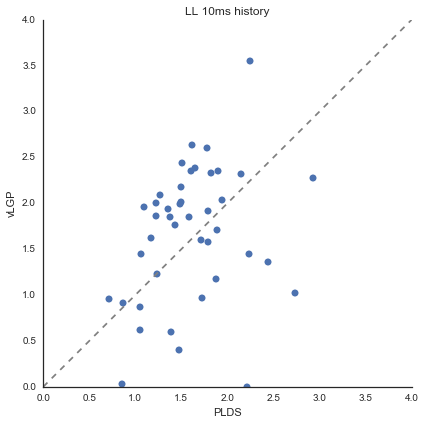

In [332]:
LL = np.zeros((nsample, ntrial, 3))
y = np.zeros((nsample, ntrial, ntime, nspike), dtype=float)
for i in range(nsample):
    y[i, :] = GP_vLGP_CV_true[i]['y']
    LL[i, :, 2] = np.nansum(stats.poisson.logpmf(y[i, :], GP_vLGP_CV_true[i]['yhat']), axis=(1, 2))
#     LL[i, :, 2] = np.nansum(stats.poisson.logpmf(y[i, :], fr[i]), axis=(1, 2))
    LL[i, :, 0] = np.sum(stats.poisson.logpmf(y[i, :], GP_PLDS_CV[i]['yhat']), axis=(1, 2))
nullyhat = np.repeat(y.mean(axis=2), ntime, axis=2).reshape((nsample, ntrial, ntime, nspike))
nullLL = np.nansum(stats.poisson.logpmf(y, nullyhat), axis=(2, 3))
plt.figure(figsize=(6, 6));
plt.plot((LL[:, :, 0].ravel() - nullLL.ravel()) / ntime / np.log(2), (LL[:, :, 2].ravel() - nullLL.ravel()) / ntime / np.log(2), ls='', marker='o');
sns.despine(right=True, top=True);
# plt.axes().set_aspect('equal', 'datalim');
plt.xlabel('PLDS');
plt.ylabel('vLGP');
plt.xlim([0, 4]);
plt.ylim([0, 4]);
# plt.title('LL 10ms history');
# plt.legend(loc='upper right');
plt.tight_layout();
plt.plot([0, 4], [0, 4], ls='--', c='gray');